# **I. Perkenalan**

```
=======================================================================================================================================
Graded Challenge 5

Nama  : Achmed Alridho Zulkarnaen
Batch : RMT-037

File ipynb ini berisikan pembuatan machine learning model yang dapat memprediksi apakah pengguna baru kemungkinan akan melakukan pembelian dimasa mendatang atau tidak.
=======================================================================================================================================
```

# **II. Query SQL**

### Dataset 1

```sql
------ dataset_1 ------
SELECT * EXCEPT(fullVisitorId)

FROM
  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1 #gunakan hanya untuk pengunjung baru
    AND date BETWEEN '20160801' AND '20170531') # latih hanya pada 10 bulan pertama
  JOIN
  (SELECT
    fullvisitorid,
    # membuat label atau target
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
  ;
```

### Dataset 2

```sql
------ dataset_2 ------
WITH all_visitor_stats AS (
  SELECT
    fullvisitorid,
    # 1. Membuat label atau target "will_buy_on_return_visit"
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
    `data-to-insights.ecommerce.web_analytics`
  GROUP BY
    fullvisitorid
)

SELECT * EXCEPT(unique_session_id)
FROM (
  SELECT
    CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
    will_buy_on_return_visit,
    
    # 2. lengkapi code berikut ini dengan ketentuan ubahlah type datanya menjadi integer dan hilangkan komentar pada code tersebut.
    MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

    # perilaku pengguna di situs web
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site,
    totals.pageviews,

    # informasi dari mana pengunjung itu berasal
    trafficSource.source,
    trafficSource.medium,
    channelGrouping,

    # informasi tentang device yang digunakan user
    device.deviceCategory,

    # informasi tentang geografi user
    IFNULL(geoNetwork.country, "Unknown") AS country

  FROM
    `data-to-insights.ecommerce.web_analytics`,
    UNNEST(hits) AS h

    JOIN all_visitor_stats USING(fullvisitorid)

  WHERE
    totals.newVisits = 1
    # 3. Menggunakan data dari tanggal '20160801' hingga '20170531'
    AND DATE BETWEEN '20160801' AND '20170531'

  GROUP BY
    unique_session_id,
    will_buy_on_return_visit,
    bounces,
    time_on_site,
    totals.pageviews,
    trafficSource.source,
    trafficSource.medium,
    channelGrouping,
    device.deviceCategory,
    country
);
```

# **III. Pendahuluan**

### Latar Belakang
Sebagai seorang Data Scientist di perusahaan e-commerce besar, saya bertugas memberikan wawasan mendalam mengenai perilaku pengguna, khususnya pengguna baru. Perusahaan ini unggul dalam menghadirkan pengalaman pengguna yang dipersonalisasi, penawaran yang tepat sasaran, serta proses transaksi yang lancar, menjadikannya favorit bagi konsumen online. Dalam persaingan ketat industri e-commerce, kemampuan mengidentifikasi calon pelanggan potensial sangat penting untuk meningkatkan konversi dan menjaga loyalitas. Menggunakan data dari Google Analytics dan algoritma Machine Learning, saya mengembangkan model untuk mengklasifikasikan potensi pembelian pengguna baru, dengan tujuan meningkatkan efektivitas kampanye pemasaran.

### Objective
Proyek ini bertujuan mengembangkan model Machine Learning untuk mengklasifikasikan apakah pengguna baru akan melakukan pembelian di masa depan. Model ini menggunakan data historis perilaku pengguna dari Google Analytics, termasuk interaksi di situs, asal traffic, dan durasi kunjungan. Hasil klasifikasi ini akan memungkinkan perusahaan memberikan promosi yang lebih tepat sasaran, meningkatkan efisiensi kampanye pemasaran, dan memperkuat hubungan dengan pelanggan potensial.

# **IV. Import Libraries**

In [272]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import pickle
import re

from phik.report import plot_correlation_matrix
#import FE
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

#import model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score, learning_curve

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score

from sklearn.model_selection import RandomizedSearchCV

from feature_engine.outliers import Winsorizer

from imblearn.over_sampling import RandomOverSampler

In [2]:
import sklearn
print(sklearn.__version__)

1.5.2


# **V. Data Loading**

### dataset_1

In [3]:
df1 = pd.read_csv('dataset_1.csv')
df1

,bounces,time_on_site,will_buy_on_return_visit
0,0,54,0
1,0,167,0
2,0,184,0
3,0,141,0
4,0,715,0
...,...,...,...
623996,0,41,0
623997,0,27,0
623998,0,50,0
623999,0,188,0


In [4]:
#Duplicate Dataset
df1_duplicate = df1.copy()

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624001 entries, 0 to 624000
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   bounces                   624001 non-null  int64
 1   time_on_site              624001 non-null  int64
 2   will_buy_on_return_visit  624001 non-null  int64
dtypes: int64(3)
memory usage: 14.3 MB


In [6]:
#check dataset - 1
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
bounces,624001.0,0.500844,0.500000,0.0,0.0,1.0,1.0,1.0
time_on_site,624001.0,120.897494,331.077426,0.0,0.0,0.0,81.0,15047.0
will_buy_on_return_visit,624001.0,0.015460,0.123373,0.0,0.0,0.0,0.0,1.0


In [7]:
df1.duplicated().sum()

np.int64(618597)

dataset_1 = Karena ini merupakan data log web, ada kemungkinan bahwa beberapa pengguna melakukan tindakan yang sama beberapa kali, dan ini merupakan informasi yang berharga. Dalam kasus ini, duplikat memberikan representasi perilaku yang sebenarnya dan dapat membantu model belajar lebih baik. Maka dari itu saya putuskan untuk tidak di buang

In [8]:
# Remove Whitespace judul column
df1.columns = df1.columns.str.strip()

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624001 entries, 0 to 624000
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   bounces                   624001 non-null  int64
 1   time_on_site              624001 non-null  int64
 2   will_buy_on_return_visit  624001 non-null  int64
dtypes: int64(3)
memory usage: 14.3 MB


### dataset_2

In [10]:
df2 = pd.read_csv('dataset_2.csv')
df2

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,0,705,5.0,google,organic,Organic Search,desktop,Poland
1,0,0,0,1448,5.0,google,organic,Organic Search,desktop,Germany
2,0,0,0,186,3.0,googleweblight.com,referral,Referral,mobile,India
3,0,0,0,1380,5.0,google,organic,Organic Search,desktop,Taiwan
4,0,0,0,238,5.0,google,organic,Organic Search,desktop,United Kingdom
...,...,...,...,...,...,...,...,...,...,...
623935,0,0,0,72,3.0,youtube.com,referral,Social,desktop,Canada
623936,0,0,0,48,3.0,youtube.com,referral,Social,mobile,United States
623937,0,0,0,102,2.0,youtube.com,referral,Social,desktop,Netherlands
623938,0,0,0,40,3.0,youtube.com,referral,Social,tablet,United States


In [11]:
df2[df2['channelGrouping'] == '(Other)']

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
55920,0,0,0,89,2.0,Partners,(not set),(Other),desktop,Kenya
82662,0,2,0,316,17.0,google,(not set),(Other),desktop,United States
91090,0,2,0,998,6.0,google,(not set),(Other),mobile,United States
135664,0,0,0,65,3.0,google,(not set),(Other),mobile,United States
143189,0,0,0,37,4.0,google,(not set),(Other),desktop,United States
197275,0,0,1,0,1.0,google,(not set),(Other),desktop,United States
197364,0,0,1,0,1.0,google,(not set),(Other),mobile,United States
197843,0,0,1,0,1.0,Partners,(not set),(Other),desktop,United States
215941,0,0,0,21,3.0,google,(not set),(Other),desktop,United States
216294,0,0,0,13,3.0,google,(not set),(Other),desktop,United States


In [12]:
df2['country'].unique()

array(['Poland', 'Germany', 'India', 'Taiwan', 'United Kingdom',
       'Indonesia', 'Philippines', 'Kyrgyzstan', 'Ukraine', 'Brazil',
       'Egypt', 'Japan', 'United States', 'France', 'Hungary', 'Mexico',
       'United Arab Emirates', 'Peru', 'Thailand', 'Argentina',
       'Colombia', 'Netherlands', 'Vietnam', 'Italy', 'Denmark',
       'Morocco', 'Israel', 'Greece', 'Spain', 'South Korea', 'Malaysia',
       'China', 'Oman', 'Austria', 'Saudi Arabia', 'Russia', 'Portugal',
       'Norway', 'Hong Kong', 'Tanzania', 'Georgia', 'Czechia', 'Belgium',
       'Turkey', 'Belarus', 'Singapore', 'Ireland', 'Canada', 'Romania',
       'Pakistan', 'Switzerland', 'Venezuela', '(not set)', 'New Zealand',
       'Australia', 'Bulgaria', 'Bangladesh', 'Slovenia', 'Chile',
       'Costa Rica', 'Kenya', 'Benin', 'Iraq', 'Algeria', 'Ecuador',
       'Croatia', 'Madagascar', 'Côte d’Ivoire', 'Puerto Rico', 'Sweden',
       'South Africa', 'Congo - Kinshasa', 'Kazakhstan', 'Jordan',
       'Serbia',

In [13]:
df2['country'].unique()

array(['Poland', 'Germany', 'India', 'Taiwan', 'United Kingdom',
       'Indonesia', 'Philippines', 'Kyrgyzstan', 'Ukraine', 'Brazil',
       'Egypt', 'Japan', 'United States', 'France', 'Hungary', 'Mexico',
       'United Arab Emirates', 'Peru', 'Thailand', 'Argentina',
       'Colombia', 'Netherlands', 'Vietnam', 'Italy', 'Denmark',
       'Morocco', 'Israel', 'Greece', 'Spain', 'South Korea', 'Malaysia',
       'China', 'Oman', 'Austria', 'Saudi Arabia', 'Russia', 'Portugal',
       'Norway', 'Hong Kong', 'Tanzania', 'Georgia', 'Czechia', 'Belgium',
       'Turkey', 'Belarus', 'Singapore', 'Ireland', 'Canada', 'Romania',
       'Pakistan', 'Switzerland', 'Venezuela', '(not set)', 'New Zealand',
       'Australia', 'Bulgaria', 'Bangladesh', 'Slovenia', 'Chile',
       'Costa Rica', 'Kenya', 'Benin', 'Iraq', 'Algeria', 'Ecuador',
       'Croatia', 'Madagascar', 'Côte d’Ivoire', 'Puerto Rico', 'Sweden',
       'South Africa', 'Congo - Kinshasa', 'Kazakhstan', 'Jordan',
       'Serbia',

In [14]:
#Duplicate Dataset
df2_duplicate = df2.copy()

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623940 entries, 0 to 623939
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   will_buy_on_return_visit   623940 non-null  int64  
 1   latest_ecommerce_progress  623940 non-null  int64  
 2   bounces                    623940 non-null  int64  
 3   time_on_site               623940 non-null  int64  
 4   pageviews                  623926 non-null  float64
 5   source                     623940 non-null  object 
 6   medium                     623940 non-null  object 
 7   channelGrouping            623940 non-null  object 
 8   deviceCategory             623940 non-null  object 
 9   country                    623940 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 47.6+ MB


In [16]:
#check dataset - 2
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
will_buy_on_return_visit,623940.0,0.015461,0.123379,0.0,0.0,0.0,0.0,1.0
latest_ecommerce_progress,623940.0,0.405569,1.106166,0.0,0.0,0.0,0.0,6.0
bounces,623940.0,0.500795,0.500000,0.0,0.0,1.0,1.0,1.0
time_on_site,623940.0,120.909313,331.091452,0.0,0.0,0.0,81.0,15047.0
pageviews,623926.0,3.791554,6.697414,1.0,1.0,1.0,4.0,466.0


In [17]:
df2.duplicated().sum()

np.int64(438629)

dataset_2 = Karena ini merupakan data log web, ada kemungkinan bahwa beberapa pengguna melakukan tindakan yang sama beberapa kali, dan ini merupakan informasi yang berharga. Dalam kasus ini, duplikat memberikan representasi perilaku yang sebenarnya dan dapat membantu model belajar lebih baik. Maka dari itu saya putuskan untuk tidak di buang

In [18]:
# Remove Whitespace judul column
df2.columns = df2.columns.str.strip()
# Remove Whitespace semua column
for col in df2.columns:
    if df2[col].dtype == "object":
        df2.loc[:, col] = df2[col].str.strip()

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623940 entries, 0 to 623939
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   will_buy_on_return_visit   623940 non-null  int64  
 1   latest_ecommerce_progress  623940 non-null  int64  
 2   bounces                    623940 non-null  int64  
 3   time_on_site               623940 non-null  int64  
 4   pageviews                  623926 non-null  float64
 5   source                     623940 non-null  object 
 6   medium                     623940 non-null  object 
 7   channelGrouping            623940 non-null  object 
 8   deviceCategory             623940 non-null  object 
 9   country                    623940 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 47.6+ MB


# **VI. Exploratory Data Analysis (EDA)**

#### Membuat copy dari df2

In [20]:
df_eda = df2.copy()
df_eda

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,0,705,5.0,google,organic,Organic Search,desktop,Poland
1,0,0,0,1448,5.0,google,organic,Organic Search,desktop,Germany
2,0,0,0,186,3.0,googleweblight.com,referral,Referral,mobile,India
3,0,0,0,1380,5.0,google,organic,Organic Search,desktop,Taiwan
4,0,0,0,238,5.0,google,organic,Organic Search,desktop,United Kingdom
...,...,...,...,...,...,...,...,...,...,...
623935,0,0,0,72,3.0,youtube.com,referral,Social,desktop,Canada
623936,0,0,0,48,3.0,youtube.com,referral,Social,mobile,United States
623937,0,0,0,102,2.0,youtube.com,referral,Social,desktop,Netherlands
623938,0,0,0,40,3.0,youtube.com,referral,Social,tablet,United States


In [21]:
df_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
will_buy_on_return_visit,623940.0,0.015461,0.123379,0.0,0.0,0.0,0.0,1.0
latest_ecommerce_progress,623940.0,0.405569,1.106166,0.0,0.0,0.0,0.0,6.0
bounces,623940.0,0.500795,0.500000,0.0,0.0,1.0,1.0,1.0
time_on_site,623940.0,120.909313,331.091452,0.0,0.0,0.0,81.0,15047.0
pageviews,623926.0,3.791554,6.697414,1.0,1.0,1.0,4.0,466.0


Dari statistik deskriptif ini, terlihat bahwa sebagian besar pengguna tidak melanjutkan pembelian (mean "will_buy_on_return_visit" sangat rendah). Interaksi pengguna di situs juga rendah, dengan median "time_on_site" dan "pageviews" berada di angka rendah (0 dan 1 berturut-turut). Fitur "bounces" menunjukkan hampir setengah dari sesi pengunjung adalah bouncing. Secara keseluruhan, pengguna cenderung memiliki keterlibatan yang rendah.

In [22]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623940 entries, 0 to 623939
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   will_buy_on_return_visit   623940 non-null  int64  
 1   latest_ecommerce_progress  623940 non-null  int64  
 2   bounces                    623940 non-null  int64  
 3   time_on_site               623940 non-null  int64  
 4   pageviews                  623926 non-null  float64
 5   source                     623940 non-null  object 
 6   medium                     623940 non-null  object 
 7   channelGrouping            623940 non-null  object 
 8   deviceCategory             623940 non-null  object 
 9   country                    623940 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 47.6+ MB


Dataset ini memiliki 623,940 entri dan 10 kolom. Sebagian besar kolom memiliki nilai yang lengkap, namun kolom "pageviews" memiliki beberapa nilai yang hilang (14 nilai yang tidak lengkap). Data terdiri dari berbagai tipe, termasuk integer, float, dan objek. Secara keseluruhan, dataset ini hampir lengkap, tetapi perlu handling missing value pada kolom "pageviews".

interval columns not set, guessing: ['bounces', 'time_on_site', 'pageviews', 'will_buy_on_return_visit']


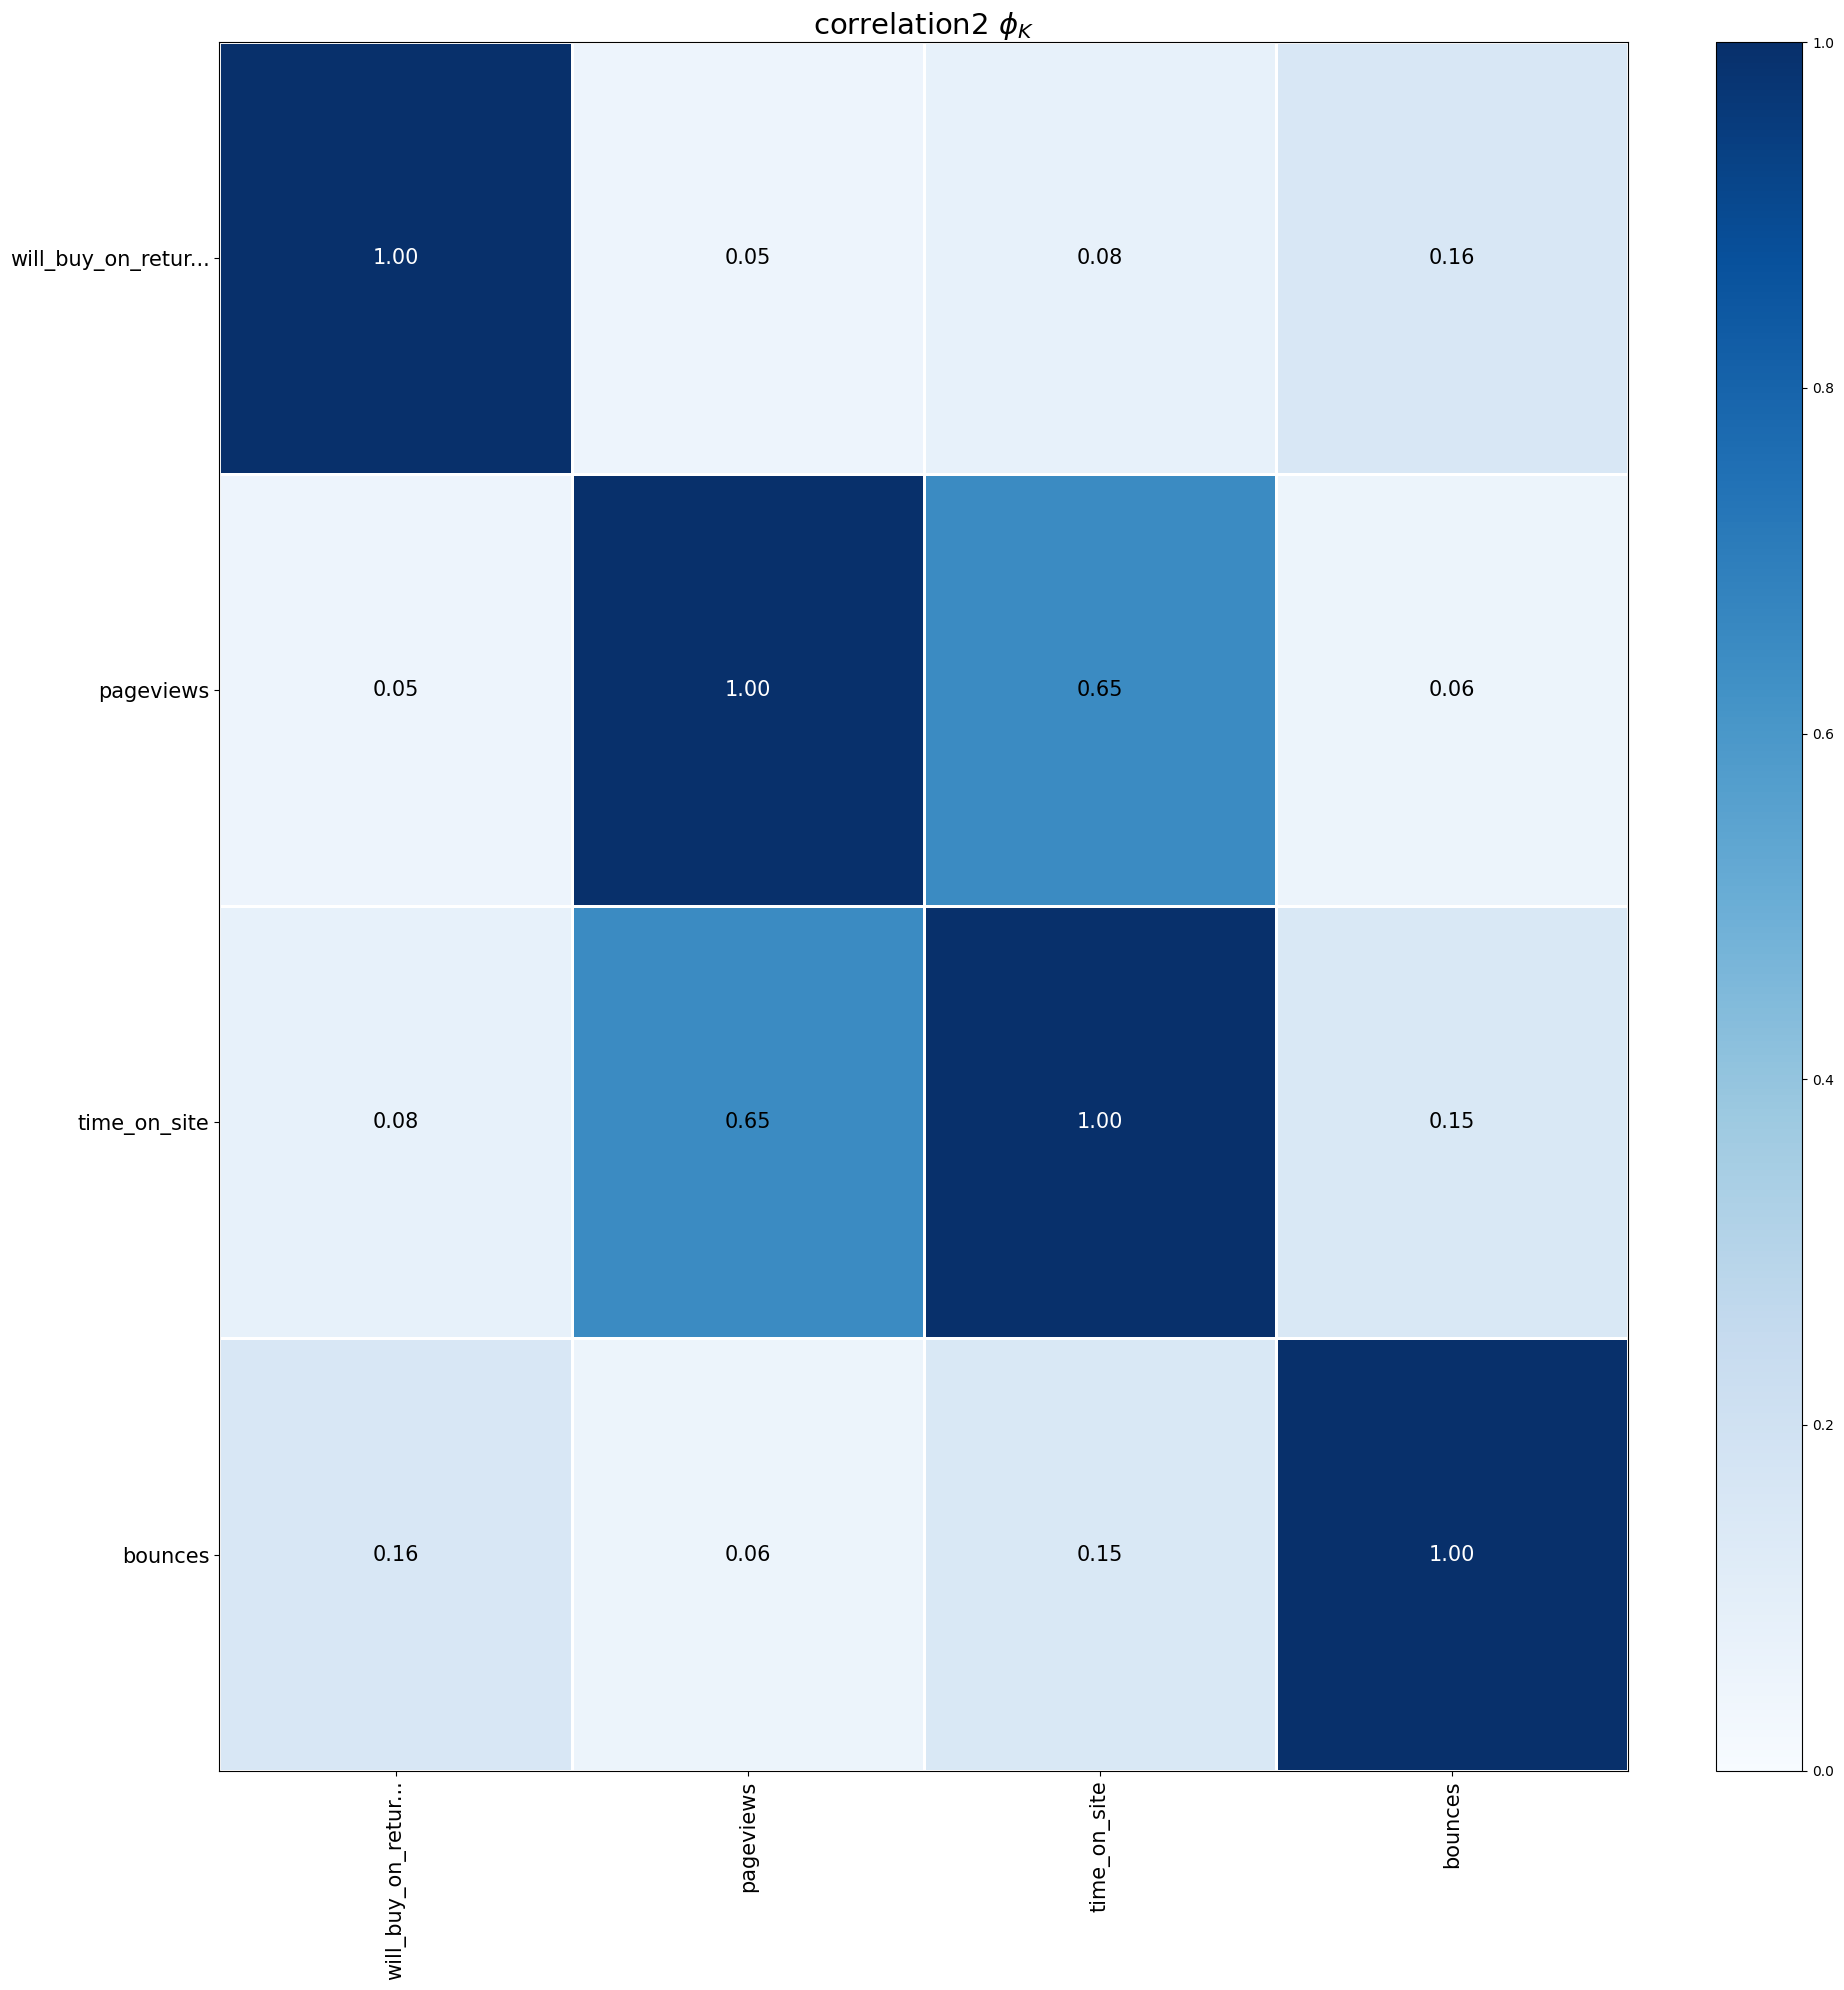

In [23]:
# Create function to correlate variables with default
def compute_phik_correlation(dataframe, columns):
    subset = dataframe[columns]
    correlation_matrix = subset.phik_matrix()
    return correlation_matrix

# Define the list of columns for each subset
columns = ['bounces','time_on_site','pageviews','will_buy_on_return_visit']

# Compute Phi-K correlation for each set of columns and print
correlation_eda = compute_phik_correlation(df_eda, columns)

plot_correlation_matrix(correlation_eda.values, x_labels=correlation_eda.columns, y_labels=correlation_eda.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation2 $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,20))
plt.tight_layout()

Menurut https://www.andrews.edu:
- Kolerasi `0.7` - `0.9` merupakan **highly colerated**
- Kolerasi `0.5` - `0.7` merupakan **moderately colerated**
- Kolerasi `0.3` - `0.5` merupakan **low colerated**

Berdasarkan heatmap korelasi dan panduan dari Andrews University:

* bounces memiliki korelasi 0.16 dengan target will_buy_on_return_visit, yang tergolong sangat rendah (kurang dari 0.3).
* time_on_site memiliki korelasi 0.08, juga tergolong sangat rendah.
* pageviews memiliki korelasi 0.05, yang juga berada pada tingkat korelasi sangat rendah.

Dengan demikian, ketiga fitur ini termasuk kategori sangat rendah dalam hal korelasi terhadap target, artinya fitur-fitur ini tidak memiliki pengaruh signifikan dalam memprediksi apakah pengguna akan melakukan pembelian saat kembali. Disarankan untuk mencari atau menciptakan fitur lain yang lebih relevan.

In [24]:
# Filter data hanya untuk pengguna dari Canada yang berpotensi melakukan pembelian kembali
canadadat = df_eda[(df_eda['country'] == 'Canada') & (df_eda['will_buy_on_return_visit'] == 1)]
# Jenis-jenis device yang digunakan oleh user di wilayah 'Canada' dengan 'will_buy_on_return_visit' = 1
device_usage = canadadat['deviceCategory'].value_counts()
print("Jenis-jenis device yang digunakan oleh user di wilayah 'Canada' dengan 'will_buy_on_return_visit' = 1:\n", device_usage)

Jenis-jenis device yang digunakan oleh user di wilayah 'Canada' dengan 'will_buy_on_return_visit' = 1:
 deviceCategory
desktop    189
mobile      11
tablet       1
Name: count, dtype: int64


Jenis device yang paling sering digunakan oleh user di wilayah Canada yang berpotensi melakukan pembelian saat mengunjungi kembali website adalah:

`desktop` dengan `189` pembelian

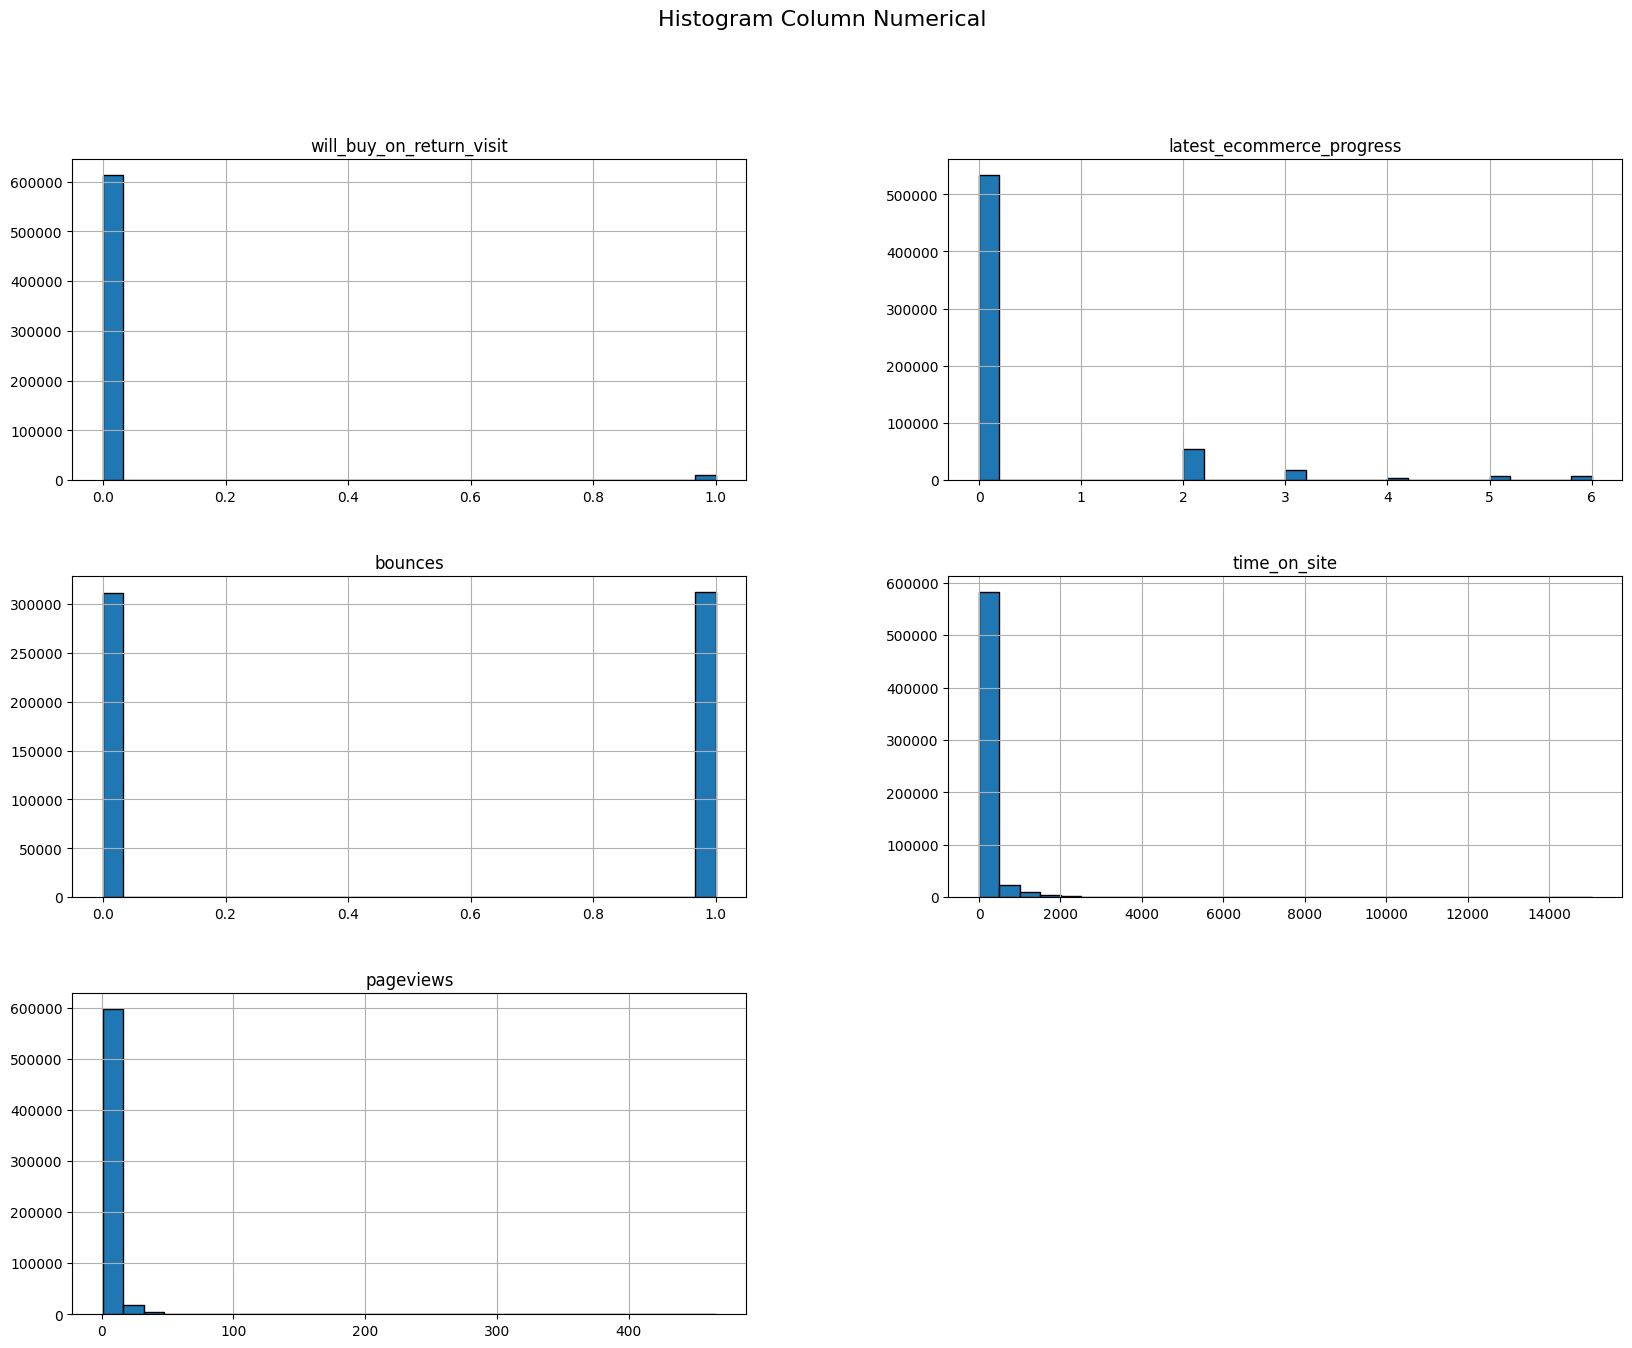

In [25]:
# Membuat histogram untuk seluruh kolom numerik, termasuk 'price'
df_eda.hist(figsize=(20, 15), bins=30, edgecolor='black')
plt.suptitle('Histogram Column Numerical', fontsize=16)
plt.show()

* Will Buy on Return Visit: Sebagian besar pengguna tidak melakukan pembelian saat kembali berkunjung, menunjukkan distribusi yang sangat tidak seimbang dengan dominasi nilai 0.

* Latest Ecommerce Progress: Mayoritas pengguna tidak melanjutkan progres ke tahap lebih lanjut dalam e-commerce, dengan distribusi yang menurun tajam pada nilai lebih tinggi dari 0, menunjukkan sedikitnya pengguna yang mencapai tahap lebih tinggi.

* Bounces: Data menunjukkan distribusi yang hampir merata antara pengguna yang melakukan "bounce" (keluar setelah mengunjungi satu halaman) dan yang tidak, mengindikasikan sebagian besar sesi pengguna berakhir dengan segera.

* Time on Site: Sebagian besar pengguna menghabiskan waktu yang sangat singkat di situs, dengan penurunan tajam pada jumlah pengguna dengan waktu lebih lama. Terdapat beberapa pengguna yang menghabiskan waktu cukup lama sebagai outlier.

* Pageviews: Mayoritas pengguna melihat sedikit halaman, dengan penurunan tajam pada jumlah pageviews yang lebih besar, menunjukkan sebagian besar sesi memiliki interaksi yang minim.

Secara keseluruhan, sebagian besar pengguna tidak melanjutkan proses pembelian dan hanya menghabiskan waktu yang singkat di situs dengan sedikit pageviews, yang menunjukkan tingkat keterlibatan yang rendah. Hanya sedikit pengguna yang menunjukkan lebih banyak interaksi atau mencapai tahapan lebih lanjut, yang dianggap sebagai outlier.

# **VII. Modeling 1 - Dari dataset dataset_1.csv**

### **1. Feature Engineering**

#### Split between X (Features) and y (target)

In [26]:
#Splitting between 'X' and 'y'
X = df1.drop(['will_buy_on_return_visit'], axis = 1)
y = df1['will_buy_on_return_visit']
X

,bounces,time_on_site
0,0,54
1,0,167
2,0,184
3,0,141
4,0,715
...,...,...
623996,0,41
623997,0,27
623998,0,50
623999,0,188


#### Splitting between Train-Set and Test-set

In [27]:
# Splitting between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 69)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (499200, 2)
Test Size:  (124801, 2)


#### Cardinality

Tidak ada cardinality check karena semua column numerical

#### Handling Missing Value

In [28]:
# Melihat apakah ada null dari setiap column X_train
X_train.isnull().sum()

bounces         0
time_on_site    0
dtype: int64

In [29]:
# Melihat apakah ada null dari setiap column X_test
X_test.isnull().sum()

bounces         0
time_on_site    0
dtype: int64

Melakukan cek distribusi apakah normal atau skewed

In [30]:
# Melihat apakah ada null dari setiap column y_train
y_train.isnull().sum()

np.int64(0)

In [31]:
# Melihat apakah ada null dari setiap column y_test
y_test.isnull().sum()

np.int64(0)

* Karena seluruh data tidak ditemuka missing value, maka missing value handling tidak dilakukan

#### Handling Outlier

In [32]:
# Check distribution form skewness
num_cols = list(X_train.select_dtypes(exclude='object').columns)

listItem= []

for col in num_cols:
  listItem.append([col, round(X_train[col].skew(),1), np.where(
    (round(X_train[col].skew(),1) <= 0.5) & (round(X_train[col].skew(),1) >= -0.5),
    'normal',
    'skewed')])



skewness = pd.DataFrame(columns=['nama kolom', 'nilai skewness', 'distribution'], data= listItem)
skewness

,nama kolom,nilai skewness,distribution
0,bounces,-0.0,normal
1,time_on_site,6.1,skewed


Kolom bounces memiliki skewness -0.0, artinya distribusinya normal atau mendekati simetris.

Kolom time_on_site memiliki skewness 6.1, artinya distribusinya sangat miring (skewed) ke kanan, menunjukkan ada banyak nilai rendah dan beberapa nilai sangat tinggi.

In [33]:
# Mendapatkan kolom numerik dari X_train
num_train = X_train._get_numeric_data()

for k, v in num_train.items():
    # Cek skewness untuk menentukan metode yang digunakan
    if -0.5 <= round(v.skew(), 1) <= 0.5:
        # Distribusi normal -> hitung Z-score manual
        mean = v.mean()
        std = v.std()
        threshold = 3  # Threshold untuk outlier Z-score ±3

        # Identifikasi outlier berdasarkan Z-score
        v_outliers = v[(v < mean - threshold * std) | (v > mean + threshold * std)]

        # Batas bawah dan atas berdasarkan Z-score
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
    else:
        # Distribusi tidak normal -> gunakan IQR
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1
        v_outliers = v[(v < q1 - 1.5 * iqr) | (v > q3 + 1.5 * iqr)]

        # Batas bawah dan atas berdasarkan IQR
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

    # Hitung persentase outlier
    perc = (len(v_outliers) / len(v)) * 100

    # Tampilkan hasil
    print(f"Column {k} - Lower bound: {round(lower_bound,3)}, Upper bound: {round(upper_bound,3)}, Outliers = {perc:.2f}%")

Column bounces - Lower bound: -0.999, Upper bound: 2.001, Outliers = 0.00%
Column time_on_site - Lower bound: -121.5, Upper bound: 202.5, Outliers = 14.30%


Kolom bounces tidak memiliki outliers, sedangkan kolom time_on_site memiliki 14.3% outliers, menunjukkan adanya nilai-nilai ekstrem di dalamnya.

In [34]:
# Create function to apply winsorization
def apply_winsorization(train, capping_method='iqr', tail='both', fold=1.5, variables=['time_on_site']):
    winsoriser = Winsorizer(capping_method=capping_method, tail=tail, fold=fold, variables=variables)
    train_capped = winsoriser.fit_transform(train)
    return train_capped

In [35]:
X_train = apply_winsorization(X_train, fold=1.5)

Melakukan capping menggunakan winsorizer dengan method iqr untuk column time_on_scale saja

In [36]:
X_train

,bounces,time_on_site
361684,1,0.0
304674,1,0.0
11844,0,202.5
69141,0,101.0
429971,0,202.5
...,...,...
299286,1,0.0
440724,1,0.0
549303,1,0.0
518763,1,0.0


In [37]:
# Mendapatkan kolom numerik dari X_train
num_train = X_train._get_numeric_data()

for k, v in num_train.items():
    # Cek skewness untuk menentukan metode yang digunakan
    if -0.5 <= round(v.skew(), 1) <= 0.5:
        # Distribusi normal -> hitung Z-score manual
        mean = v.mean()
        std = v.std()
        threshold = 3  # Threshold untuk outlier Z-score ±3

        # Identifikasi outlier berdasarkan Z-score
        v_outliers = v[(v < mean - threshold * std) | (v > mean + threshold * std)]

        # Batas bawah dan atas berdasarkan Z-score
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
    else:
        # Distribusi tidak normal -> gunakan IQR
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1
        v_outliers = v[(v < q1 - 1.5 * iqr) | (v > q3 + 1.5 * iqr)]

        # Batas bawah dan atas berdasarkan IQR
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

    # Hitung persentase outlier
    perc = (len(v_outliers) / len(v)) * 100

    # Tampilkan hasil
    print(f"Column {k} - Lower bound: {round(lower_bound,3)}, Upper bound: {round(upper_bound,3)}, Outliers = {perc:.2f}%")

Column bounces - Lower bound: -0.999, Upper bound: 2.001, Outliers = 0.00%
Column time_on_site - Lower bound: -121.5, Upper bound: 202.5, Outliers = 0.00%


Dapat terlihat outlier berhasil di handling menggunakan capping method

#### Feature Selection

In [38]:
# Concatenate X_train and y_train
concat_train = pd.concat([X_train, y_train], axis=1)

# Show X_train
concat_train.head()

,bounces,time_on_site,will_buy_on_return_visit
361684,1,0.0,0
304674,1,0.0,0
11844,0,202.5,0
69141,0,101.0,0
429971,0,202.5,0


Melakukan concate untuk menggabungkan X_train, y_train

interval columns not set, guessing: ['bounces', 'time_on_site', 'will_buy_on_return_visit']


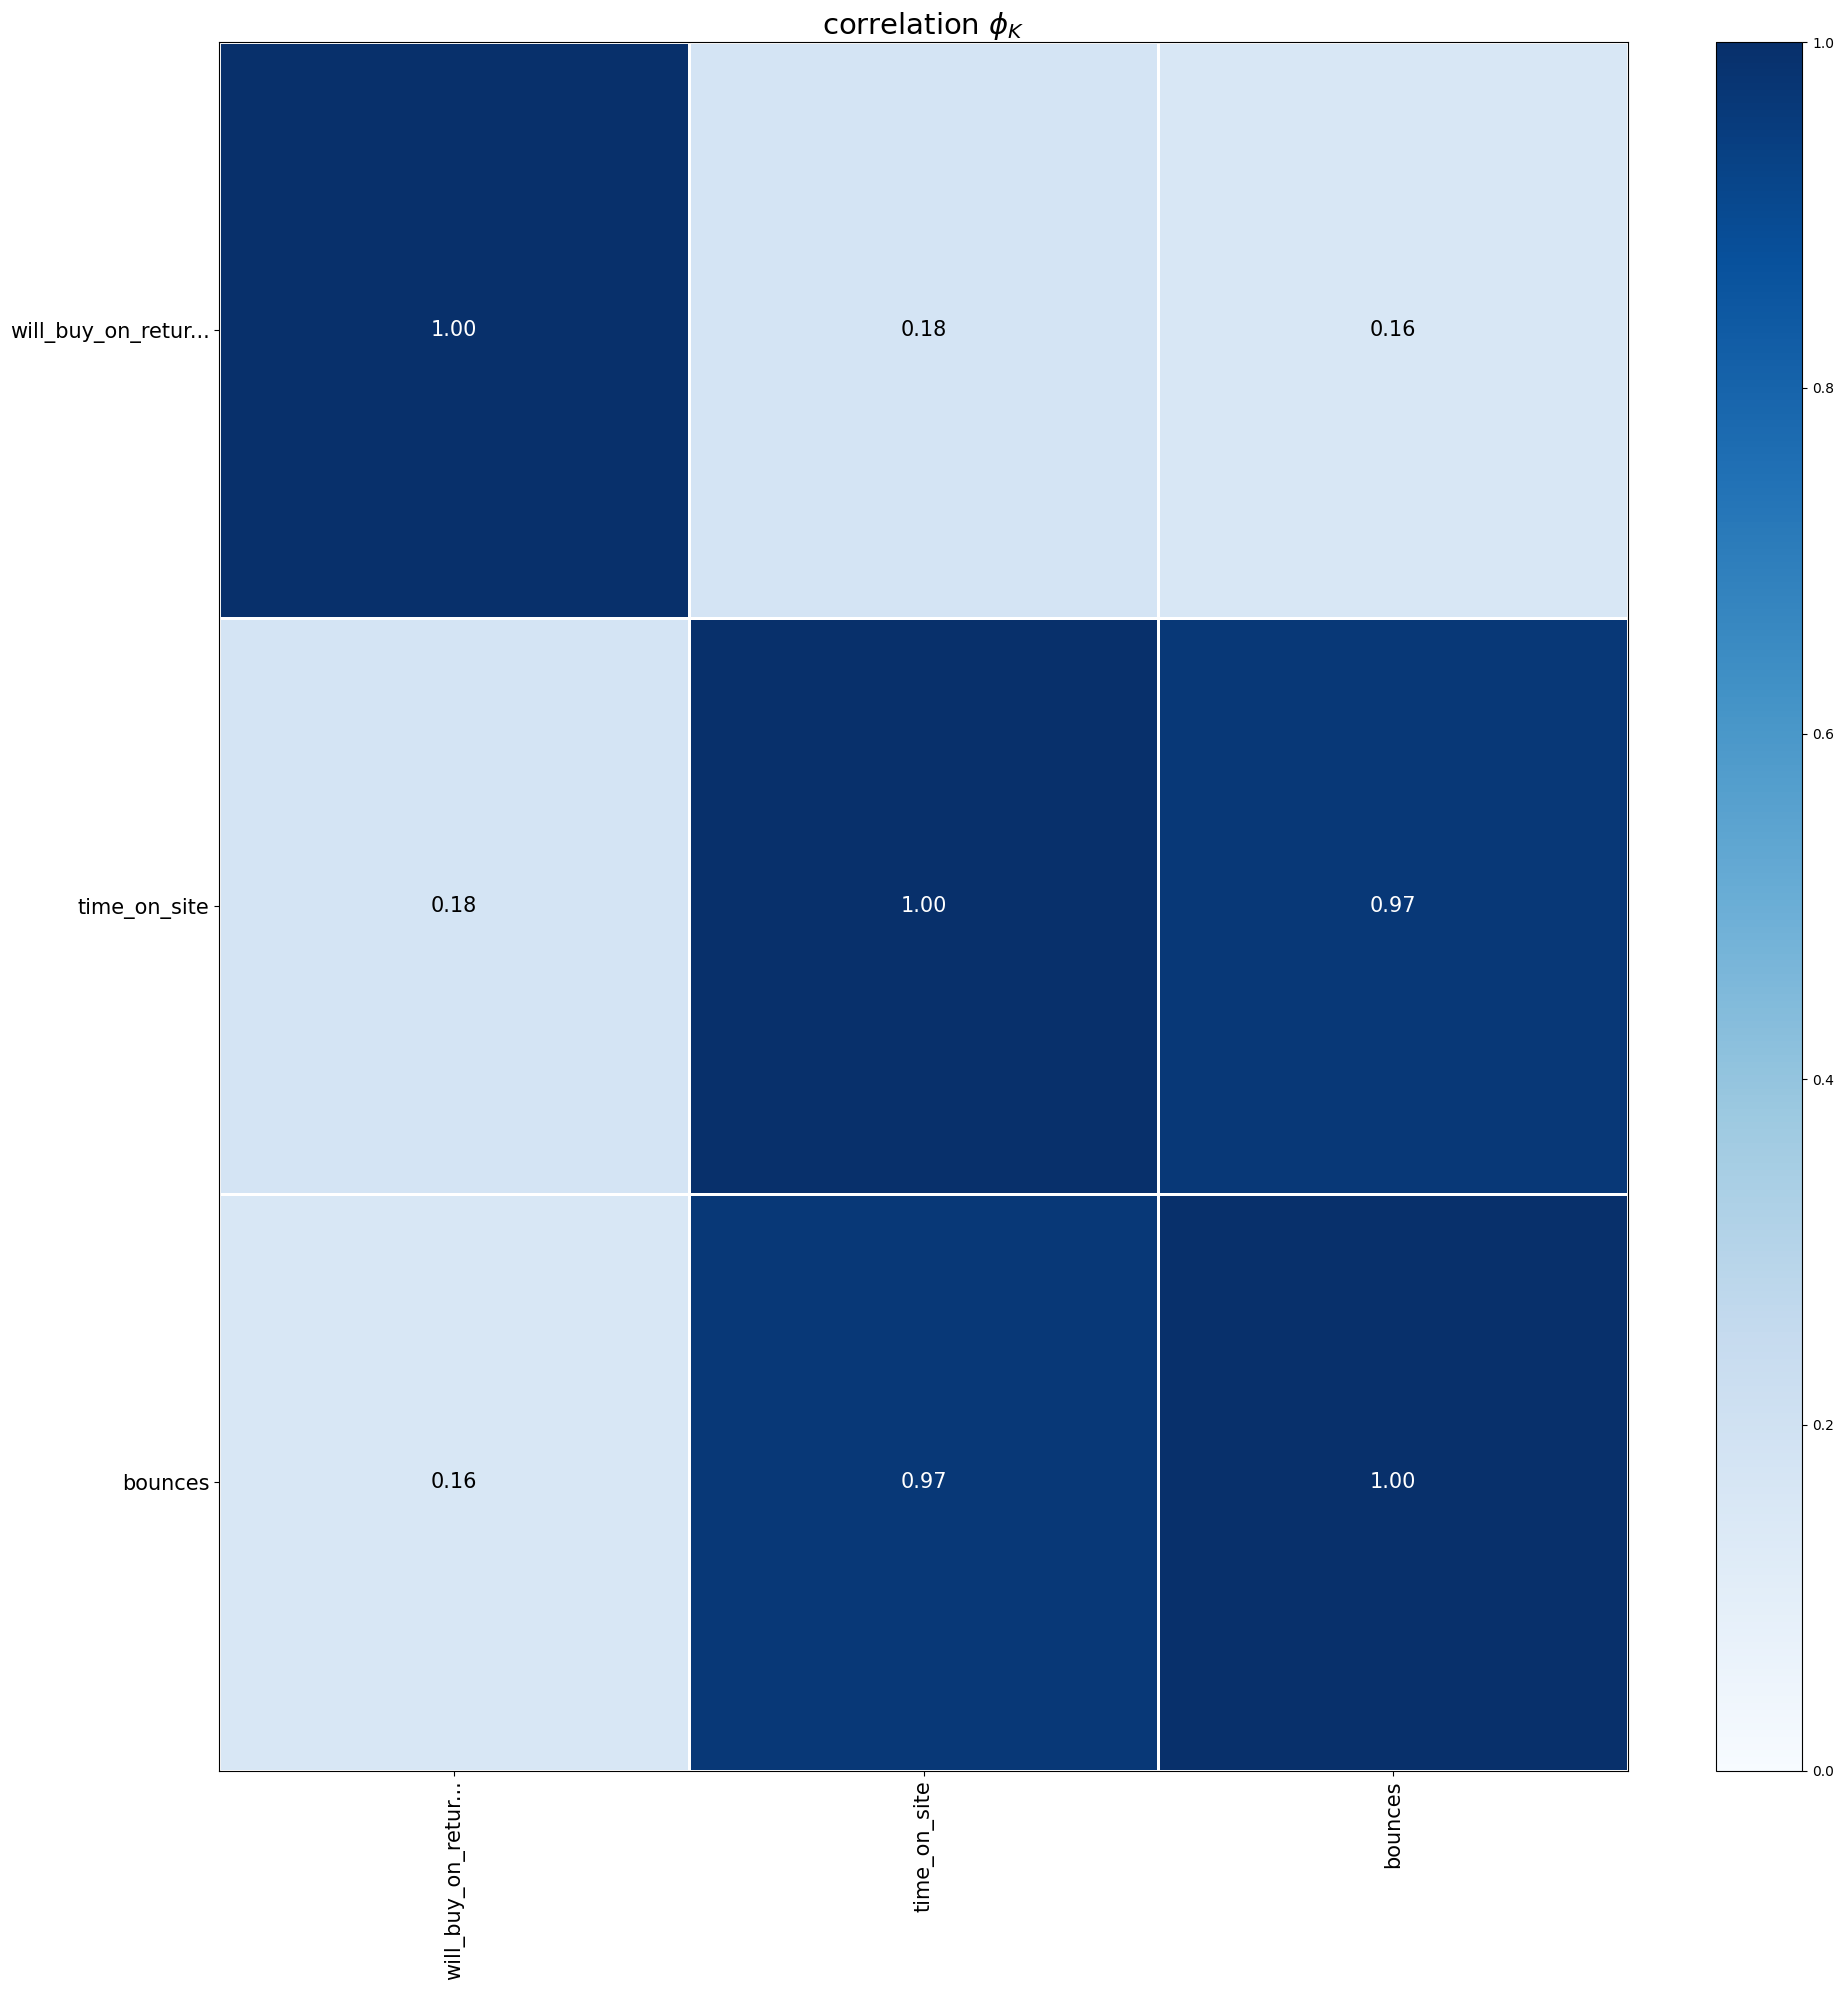

In [39]:
# Create function to correlate variables with default
def compute_phik_correlation(dataframe, columns):
    subset = dataframe[columns]
    correlation_matrix = subset.phik_matrix()
    return correlation_matrix

# Define the list of columns for each subset
columns = ['bounces','time_on_site','will_buy_on_return_visit']

# Compute Phi-K correlation for each set of columns and print
correlation = compute_phik_correlation(concat_train, columns)

plot_correlation_matrix(correlation.values, x_labels=correlation.columns, y_labels=correlation.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,20))
plt.tight_layout()

Korelasi bounces dan time_on_site sangat lemah

* Seluruh column harus dipakai tidak ada yang di drop

#### Column Transformer

In [40]:
skewness

,nama kolom,nilai skewness,distribution
0,bounces,-0.0,normal
1,time_on_site,6.1,skewed


In [41]:
# Making column transformer for preprocessing
transformer = ColumnTransformer([
    ('scaler_norm', StandardScaler(), ['bounces']),
    ('scaler_skewed', MinMaxScaler(), ['time_on_site'])
], remainder='passthrough')  # Kolom yang tidak disebutkan akan diteruskan tanpa perubahan

time_on_site menggunakan MinMaxScaler() karena distributionnya skewed

### **2. Model Definition**

* Logistic Regression cocok dalam situasi ini karena mampu mengatasi klasifikasi biner, memberikan hasil yang mudah diinterpretasi, efisien, dan memberikan probabilitas yang membantu pengambilan keputusan.
* Logistic Regression juga dipilih karena merupakan syarat dari perusahaan yang mewajibkan menggunakan algoritma ini.

### **3. Model Training**

In [42]:
#Making pipeline for LogReg
pipe_logreg = Pipeline([
('transformer', transformer),
('classifier', LogisticRegression())
])

Membuat pipeline untuk logistic regression

In [43]:
pipe_logreg.fit(X_train, y_train)
print('Training Score: ',round(pipe_logreg.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_logreg.score(X_test, y_test),4))

Training Score:  0.9845
Testing Score:  0.9348


Model Logistic Regression memiliki Training Score 98.45% dan Testing Score 93.48%, yang menunjukkan bahwa model dapat memahami data latih dengan sangat baik dan cukup mengeneralisasi data baru, meskipun ada sedikit indikasi overfitting. Perbedaan sekitar 5% antara Training dan Testing Score menunjukkan bahwa model mungkin telah sedikit menyesuaikan diri dengan data latih, sehingga akan diteliti lebih lanjut menggunakan cross-validation guna mengontrol kompleksitas dan memastikan performa yang lebih stabil pada data baru.

In [44]:
y_logreg_pred = pipe_logreg.predict(X_test)
y_logreg_pred

array([0, 0, 0, ..., 0, 0, 0])

Saya menggunakan kode y_logreg_pred = pipe_logreg.predict(X_test) untuk mendapatkan prediksi model Logistic Regression pada data uji (X_test). Prediksi ini, disimpan dalam variabel y_logreg_pred, nantinya untuk mengevaluasi seberapa baik model bekerja pada data yang belum pernah dilihatnya sebelumnya. Hasil prediksi kemudian akan dibandingkan dengan label asli (y_test) untuk menghitung berbagai metrik evaluasi seperti recall dan F1 Score, yang memberikan gambaran tentang performa model dalam klasifikasi ini.

#### Simple Evaluation LogisticRegression

```
Dalam konteks analisis ini, saya fokus pada recall, yang mengukur seberapa baik model mengenali semua sampel positif, yaitu mendeteksi dengan benar seluruh pengguna yang berpotensi melakukan pembelian (potential buyer). 

Recall juga sangat penting ketika prioritas utama adalah mengurangi False Negative, karena hal ini membantu memastikan bahwa pelanggan potensial yang mungkin akan melakukan pembelian tidak terlewatkan oleh model.
```

In [45]:
target = ['Tidak melakukan pembelian', 'Akan melakukan pembelian saat mengunjungi kembali']
print(classification_report(y_test, y_logreg_pred, target_names = target))

                                                   precision    recall  f1-score   support

                        Tidak melakukan pembelian       0.99      0.95      0.97    122874
Akan melakukan pembelian saat mengunjungi kembali       0.06      0.23      0.10      1927

                                         accuracy                           0.93    124801
                                        macro avg       0.52      0.59      0.53    124801
                                     weighted avg       0.97      0.93      0.95    124801



Karena fokus saya pada recall, hasil ini menunjukkan bahwa model kurang baik dalam mendeteksi pelanggan potensial (hanya mampu mendeteksi 23% dari mereka yang berpotensi melakukan pembelian), sementara cukup baik untuk kelas mayoritas (yang tidak membeli). Karena mengidentifikasi sebanyak mungkin pengguna potensial adalah prioritas utama saya, maka model ini membutuhkan perbaikan, terutama dalam hal meningkatkan recall untuk kelas "Akan melakukan pembelian saat mengunjungi kembali".

Meningkatkan recall untuk kelas "Akan melakukan pembelian saat mengunjungi kembali" bisa dilakukan dengan berbagai cara, seperti balancing kelas (oversampling kelas minoritas) atau menyesuaikan threshold model.

In [280]:
# Menghitung ROC AUC Score
roc_auc = roc_auc_score(y_test, y_logreg_pred)

In [284]:
# Membuat fungsi untuk cek roc_aux_score berdasarkan standar perusahaan
def check_roc_auc_score(roc_auc_score):
    if roc_auc_score > 0.9:
        return "Good"
    elif 0.8 <= roc_auc_score <= 0.9:
        return "Fair"
    elif 0.7 <= roc_auc_score < 0.8:
        return "Decent"
    elif 0.6 <= roc_auc_score < 0.7:
        return "Not Great"
    else:
        return "Poor"

result = check_roc_auc_score(roc_auc)
print(f"ROC AUC Score: {roc_auc:.3f}, Category: {result}")


ROC AUC Score: 0.588, Category: Poor


Dengan ROC AUC Score sebesar 0.588, hasil ini masuk ke dalam kategori "Poor" menurut klasifikasi yang ditetapkan oleh perusahaan. Artinya, kemampuan model untuk membedakan antara kelas positif (potential buyer) dan kelas negatif (non buyer) kurang baik, dan hanya sedikit lebih baik daripada tebakan acak. Skor ini menunjukkan bahwa model belum cukup efektif untuk memprediksi apakah pengguna akan melakukan pembelian atau tidak, sehingga memerlukan perbaikan agar memberikan hasil yang lebih akurat.

In [273]:
# Cross Validation
recall_train_cross_val = cross_val_score(pipe_logreg,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('recall Score - All - Cross Validation  : ', recall_train_cross_val)
print('recall Score - Mean - Cross Validation : ', recall_train_cross_val.mean())
print('recall Score - Std - Cross Validation  : ', recall_train_cross_val.std())
print('recall Score - Range of Test-Set       : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

recall Score - All - Cross Validation  :  [0. 0. 0.]
recall Score - Mean - Cross Validation :  0.0
recall Score - Std - Cross Validation  :  0.0
recall Score - Range of Test-Set       :  0.0 - 0.0


Model gagal total mengenali kelas positif (1) dengan recall Score = 0 pada semua fold cross-validation, menunjukkan performa yang sangat buruk. Ini kemungkinan disebabkan oleh ketidakseimbangan kelas yang perlu diatasi, misalnya dengan oversampling kelas minoritas atau menggunakan class weights.

#### Base Model Logistic Regression

In [48]:
models = {
    'Logistic Regression' : pipe_logreg
}

metrics = {
    'Recall' : recall_score
}

df1_model = pd.DataFrame(columns = models.keys())

for metric in metrics.keys():
  for model in models.keys():
    df1_model.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))
df1_model

,Logistic Regression
Recall,0.23041


Dengan Recall sebesar 0.23041, model Logistic Regression saya hanya mampu mendeteksi sekitar 23% dari pengguna yang berpotensi melakukan pembelian. Ini menunjukkan bahwa model masih banyak melewatkan pelanggan potensial, sehingga diperlukan perbaikan agar recall bisa lebih tinggi dan lebih akurat dalam mengidentifikasi peluang pembelian.

In [274]:
models = {
    'Logistic Regression' : pipe_logreg
}

metrics = {
    'Mean' : cross_val_score(models[model], X_train, y_train, cv = 3, scoring='recall').mean(),
    'Std' : cross_val_score(models[model], X_train, y_train, cv = 3, scoring='recall').std()
}

df1_cross_val = pd.DataFrame(columns = models.keys(), index = ['Mean', 'Std'])

for i in metrics.keys():
  for j in models.keys():
    df1_cross_val.loc[i, j] = metrics[i]
df1_cross_val

,Logistic Regression
Mean,0.0
Std,0.0


Model Logistic Regression memiliki Mean dan Standar Deviasi recall Score sebesar 0, yang menunjukkan bahwa model gagal mendeteksi kelas positif di semua percobaan, dan tidak ada variasi dalam hasilnya.

#### Confusion Matrix Without Tuning

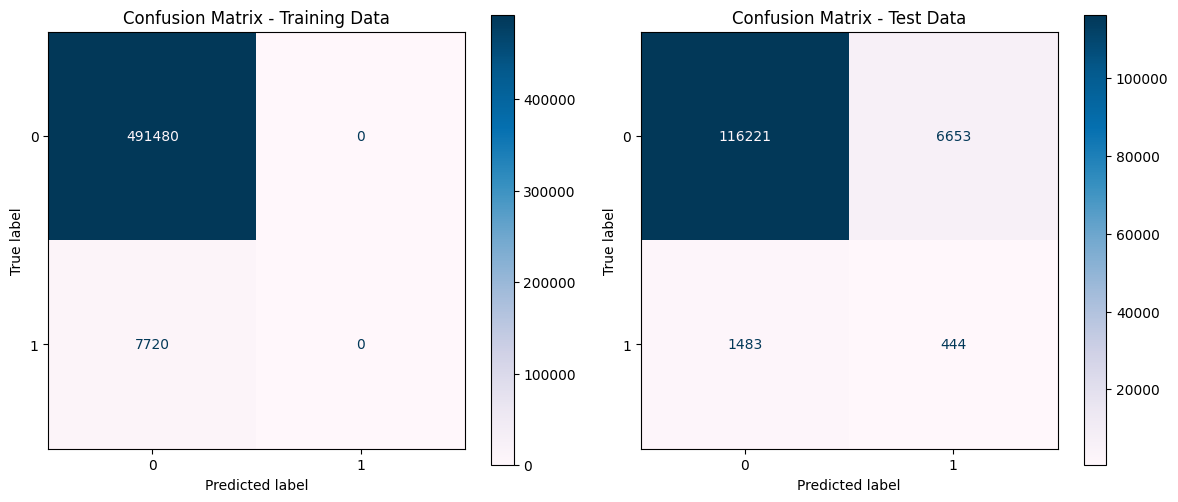

In [50]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix = ConfusionMatrixDisplay.from_estimator(pipe_logreg, X_train, y_train, cmap='PuBu', ax=axes[0])
train_matrix.ax_.set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for test data
test_matrix = ConfusionMatrixDisplay.from_estimator(pipe_logreg, X_test, y_test, cmap='PuBu', ax=axes[1])
test_matrix.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

Berdasarkan Confusion Matrix, model tidak mampu mendeteksi kelas positif (1) pada data latih (7720 false negatives dan 0 true positives), dan pada data uji pun performanya sangat buruk, dengan hanya 444 true positives dibandingkan 1483 false negatives. Ini menunjukkan bahwa model hampir selalu salah dalam mengenali pengguna yang berpotensi melakukan pembelian, sehingga memerlukan perbaikan signifikan untuk meningkatkan kemampuan klasifikasinya terhadap kelas minoritas (potential buyer).

In [51]:
y_pred_train = pipe_logreg.predict(X_train)
y_pred_test = pipe_logreg.predict(X_test)

In [52]:
# Create function to create reports
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, name):
    # Calculate recall scores
    score_reports = {
        'Recall Train Set': recall_score(y_train, y_pred_train),
        'Recall Test Set': recall_score(y_test, y_pred_test),
    }

    # Calculate confusion matrices for train and test sets
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # Extract false negatives from the confusion matrices and add to the report
    score_reports['False Negative Train'] = cm_train[1, 0]
    score_reports['False Negative Test'] = cm_test[1, 0]

    # Store the report in the dictionary with the specified model name
    all_reports[name] = score_reports
    return all_reports

all_reports = {}
all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, 'Logistic Regresion without Tuning')

pd.DataFrame(all_reports)

,Logistic Regresion without Tuning
Recall Train Set,0.00000
Recall Test Set,0.23041
False Negative Train,7720.00000
False Negative Test,1483.00000


Model Logistic Regression tanpa tuning memiliki Recall = 0 pada data latih, menunjukkan kegagalan total dalam mendeteksi kelas positif, sementara Recall = 0.23 pada data uji berarti model hanya mendeteksi 23% pelanggan potensial. Tingginya false negatives (7720 di data latih dan 1483 di data uji) menunjukkan bahwa model tidak efektif dalam mengenali pengguna yang berpotensi membeli, sehingga memerlukan perbaikan signifikan.

### **4. Model Evaluation**

#### Hyperparemeter Tuning

In [ ]:
# Set up the parameter grid for logistic regresion
param_grid_lr = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 200, 500],
    'classifier__class_weight': [None, 'balanced']
}

# Set up the GridSearchCV object for Random Forest
grid_search_lr = RandomizedSearchCV(pipe_logreg,
                                    param_distributions=param_grid_lr,
                                    scoring='recall',
                                    cv=5,
                                    verbose=2,
                                    n_jobs=-1)

# Fit GridSearchCV for Logistic Regression
grid_search_lr.fit(X_train, y_train)

# Best hyperparameters for logreg
print('Best hyperparameters for Logistic Regression:', grid_search_lr.best_params_)

# Best recall for Logistic Regression
print('Best recall for Logistic Regression:', grid_search_lr.best_score_)

# Save best Logistic Regression model to a variable
best_lr_model = grid_search_lr.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for Logistic Regression: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__max_iter': 200, 'classifier__class_weight': 'balanced', 'classifier__C': 0.01}
Best recall for Logistic Regression: 0.8006476683937823


c:\Users\Alridho\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters untuk Logistic Regression adalah:

* solver: liblinear 

* penalty: l2, 

* max_iter: 200 

* class_weight: balanced 

* C: 0.01

In [54]:
# Dapatkan prediksi untuk data latih dan data uji menggunakan model yang sudah dituning hyperparameter-nya.
y_pred_train_tuned = best_lr_model.predict(X_train)
y_pred_test_tuned = best_lr_model.predict(X_test)

In [55]:
# print(recall_score(y_test, y_pred_test_tuned))
print('Recall Score - Train Set  : ', recall_score(y_train, y_pred_train_tuned))
print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_test_tuned))

Recall Score - Train Set  :  0.5840673575129534
Recall Score - Test Set   :  0.5734302023871303


Recall Score untuk Train Set sebesar 0.58 dan Test Set sebesar 0.57 menunjukkan bahwa model berhasil mendeteksi sekitar 58% dan 57% dari sampel kelas positif (pengguna berpotensi membeli) pada data latih dan data uji. Artinya, model memiliki performa yang cukup konsisten dalam mengenali sebagian besar pengguna potensial baik pada data latih maupun data uji, namun masih ada ruang untuk meningkatkan kemampuan deteksi, terutama untuk mengurangi False Negatives dan meningkatkan identifikasi pengguna yang berpotensi melakukan pembelian.

In [56]:
# Add results to the report
all_reports = performance_report(all_reports, y_train, y_pred_train_tuned, y_test, y_pred_test_tuned, 'Logistic Regresion with Tuning')
pd.DataFrame(all_reports)

,Logistic Regresion without Tuning,Logistic Regresion with Tuning
Recall Train Set,0.00000,0.584067
Recall Test Set,0.23041,0.573430
False Negative Train,7720.00000,3211.000000
False Negative Test,1483.00000,822.000000


Setelah tuning, Recall meningkat signifikan, dari 0.0 menjadi 0.58 untuk data latih, dan dari 0.23 menjadi 0.57 untuk data uji, menunjukkan peningkatan dalam kemampuan model mendeteksi kelas positif. False negatives juga berkurang secara drastis baik pada data latih (dari 7720 menjadi 3211) maupun data uji (dari 1483 menjadi 822), menunjukkan bahwa model lebih efektif dalam mengenali pengguna yang berpotensi melakukan pembelian.

#### Confusion Matrix Setelah Tuning Logistic Regression

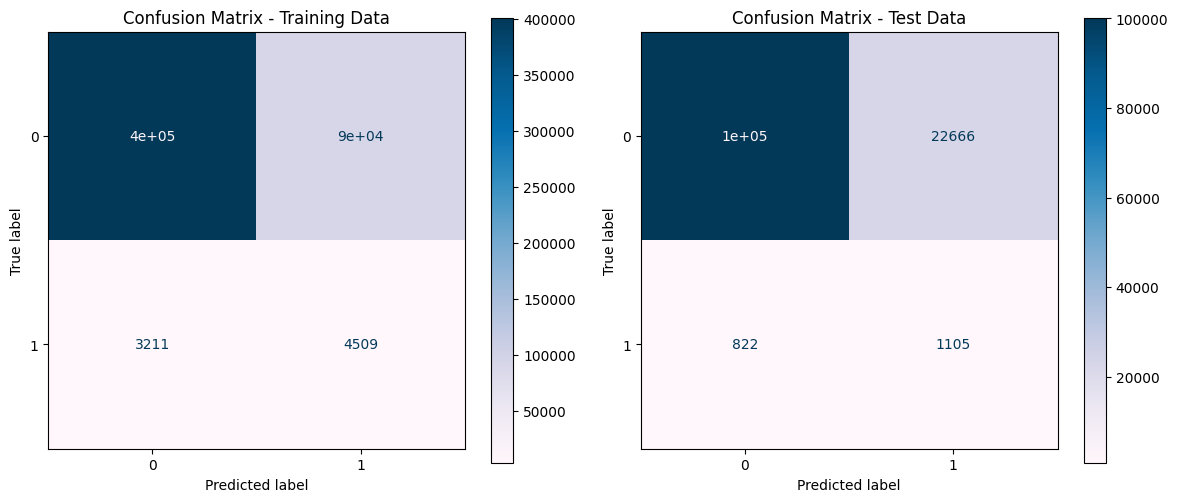

In [57]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix = ConfusionMatrixDisplay.from_estimator(best_lr_model, X_train, y_train, cmap='PuBu', ax=axes[0])
train_matrix.ax_.set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for test data
test_matrix = ConfusionMatrixDisplay.from_estimator(best_lr_model, X_test, y_test, cmap='PuBu', ax=axes[1])
test_matrix.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

Berdasarkan Confusion Matrix yang diberikan, model yang sudah melalui tuning menunjukkan peningkatan dalam mendeteksi kelas positif (potential buyer). Pada data latih, terdapat 4509 true positives dan 3211 false negatives, yang menandakan bahwa model cukup baik dalam mengenali pengguna potensial. Untuk data uji, model berhasil mengenali 1105 dari 1927 sampel kelas positif, dengan 822 false negatives. Namun, masih terdapat sejumlah false positives yang cukup besar (90,000 pada data latih dan 22,666 pada data uji), yang menunjukkan bahwa prediksi positif yang salah masih perlu dikurangi lebih lanjut. Secara keseluruhan, model lebih baik dalam mengenali pengguna potensial yang akan melakukan pembelian, tetapi masih perlu perbaikan dalam meminimalkan kesalahan prediksi.

* Selanjutnya untuk membuat model data akan ditambahkan, agar model jadi lebih baik untuk memprediksi potential buyer. Saya akan melakukan DataBalancing juga agar data seimbang dan tidak bias ke data mayoritas

# **VIII. Modeling 2 - Dari dataset dataset_2.csv**

In [217]:
df2

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,0,705,5.0,google,organic,Organic Search,desktop,Poland
1,0,0,0,1448,5.0,google,organic,Organic Search,desktop,Germany
2,0,0,0,186,3.0,googleweblight.com,referral,Referral,mobile,India
3,0,0,0,1380,5.0,google,organic,Organic Search,desktop,Taiwan
4,0,0,0,238,5.0,google,organic,Organic Search,desktop,United Kingdom
...,...,...,...,...,...,...,...,...,...,...
623935,0,0,0,72,3.0,youtube.com,referral,Social,desktop,Canada
623936,0,0,0,48,3.0,youtube.com,referral,Social,mobile,United States
623937,0,0,0,102,2.0,youtube.com,referral,Social,desktop,Netherlands
623938,0,0,0,40,3.0,youtube.com,referral,Social,tablet,United States


In [218]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623940 entries, 0 to 623939
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   will_buy_on_return_visit   623940 non-null  int64  
 1   latest_ecommerce_progress  623940 non-null  int64  
 2   bounces                    623940 non-null  int64  
 3   time_on_site               623940 non-null  int64  
 4   pageviews                  623926 non-null  float64
 5   source                     623940 non-null  object 
 6   medium                     623940 non-null  object 
 7   channelGrouping            623940 non-null  object 
 8   deviceCategory             623940 non-null  object 
 9   country                    623940 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 47.6+ MB


Seluruh column sudah sesuai data typenya, tetapi masih ada missing value pada pageviews, akan di teliti lebih lanjut pada missing value handling

### **1. Feature Engineering**

#### Split between X2 (Features) and y2 (target)

In [219]:
#Splitting between 'X2' and 'y2'
X2 = df2.drop(['will_buy_on_return_visit'], axis = 1)
y2 = df2['will_buy_on_return_visit']
X2

,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,705,5.0,google,organic,Organic Search,desktop,Poland
1,0,0,1448,5.0,google,organic,Organic Search,desktop,Germany
2,0,0,186,3.0,googleweblight.com,referral,Referral,mobile,India
3,0,0,1380,5.0,google,organic,Organic Search,desktop,Taiwan
4,0,0,238,5.0,google,organic,Organic Search,desktop,United Kingdom
...,...,...,...,...,...,...,...,...,...
623935,0,0,72,3.0,youtube.com,referral,Social,desktop,Canada
623936,0,0,48,3.0,youtube.com,referral,Social,mobile,United States
623937,0,0,102,2.0,youtube.com,referral,Social,desktop,Netherlands
623938,0,0,40,3.0,youtube.com,referral,Social,tablet,United States


#### Splitting between Train-Set and Test-set

In [220]:
# Splitting between train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 69)
print('Train Size: ', X2_train.shape)
print('Test Size: ', X2_test.shape)

Train Size:  (499152, 9)
Test Size:  (124788, 9)


#### Data Balancing (RandomOversampling)

In [ ]:
# Menggunakan RandomOverSampler untuk oversampling kelas minoritas
oversampler = RandomOverSampler(random_state=42)
X2_train, y2_train = oversampler.fit_resample(X2_train, y2_train)

# Lihat distribusi setelah Random Oversampling
print(y2_train.value_counts())

will_buy_on_return_visit
0    491407
1    491407
Name: count, dtype: int64


Saya memilih RandomOverSampler untuk mengatasi masalah ketidakseimbangan kelas dalam dataset. Dalam konteks ini, penting bagi model untuk dapat mendeteksi pengguna yang berpotensi melakukan pembelian, yang merupakan kelas minoritas. Metode model evaluation yang saya tekankan adalah recall, karena recall sangat relevan dalam kasus di mana kita ingin meminimalkan False Negatives, yaitu pengguna potensial yang tidak teridentifikasi dengan benar oleh model. Dengan menggunakan RandomOverSampler, saya memastikan bahwa model mendapat cukup banyak contoh dari kelas minoritas, sehingga dapat meningkatkan nilai recall dengan mendeteksi lebih banyak pengguna potensial. Langkah ini memungkinkan model untuk mengenali mayoritas pengguna potensial dan mengurangi risiko mengabaikan calon pembeli, yang merupakan prioritas utama dalam evaluasi performa.

#### Cardinality Handling

In [222]:
X2_train.source.value_counts().head(40)

source
google                       287598
(direct)                     252540
mall.googleplex.com          163768
youtube.com                  154442
sites.google.com              37843
moma.corp.google.com          28053
gdeals.googleplex.com         12770
Partners                       8629
dfa                            5952
analytics.google.com           5656
google.com                     2942
baidu                          2321
m.facebook.com                 1951
siliconvalley.about.com        1853
groups.google.com              1549
facebook.com                   1418
yahoo                          1388
mail.google.com                1224
bing                           1084
reddit.com                     1005
t.co                           1004
qiita.com                       982
quora.com                       746
l.facebook.com                  493
plus.google.com                 387
blog.golang.org                 366
docs.google.com                 296
connect.googleforwork

In [223]:
categories = {
    "Social Media": ["facebook.com", "m.facebook.com", "l.facebook.com", "t.co", "quora.com", "reddit.com"],
    "Search Engine": ["google", "bing", "yahoo", "baidu", "ask", "duckduckgo.com", "m.baidu.com", "google.co.jp", "google.co.uk"],
    "Google Services": ["gdeals.googleplex.com", "moma.corp.google.com", "youtube.com", "mall.googleplex.com", "analytics.google.com", "google.com", "sites.google.com", "googleweblight.com", "groups.google.com", "mail.google.com", "plus.google.com", "productforums.google.com", "docs.google.com", "googleux.perksplus.com", "googleplex.com"],
    "Advertising Platform": ["dfa"],
    "Forum": ["qiita.com", "seroundtable.com"],
    "Tech News": ["siliconvalley.about.com", "blog.golang.org", "lunametrics.com"],
    "E-commerce": ["dealspotr.com"],
    "Partners": ["Partners"]
}
# Function to categorize domain
def categorize_domain(domain):
    # Check if domain is "(not set)" or "(direct)", leave it unchanged
    if domain == "(not set)" or domain == "(direct)":
        return domain

    # Otherwise, categorize the domain
    for category, domains_list in categories.items():
        for d in domains_list:
            if re.search(r'\b' + re.escape(d) + r'\b', domain):
                return category
    return "Other"

# Adding a new column based on categorization
X2_train['source'] = X2_train['source'].apply(categorize_domain)

In [224]:
X2_test['source'] = X2_test['source'].apply(categorize_domain)

Membuat fungsi untuk handle cardinality dimana pada column 'source' ditemukan ordinality yang sangat banyak, dan saya reduced menjadi hanya 8, yaitu "Social Media", "Search Engine", "Google Services", "Advertising Platform", "Forum", "Tech News", "E-commerce", dan "Partners". Lalu saya apply ke X2_train dan X2_test.

* Selanjutnya saya lakukan hal yang sama ke column country

In [226]:
X2_train.country.value_counts().head(50)

country
United States           636172
India                    30248
Canada                   22881
United Kingdom           21412
Vietnam                  18096
Turkey                   14682
Thailand                 14619
Brazil                   13708
Germany                  11752
Japan                    11521
Mexico                    8826
France                    8825
Russia                    7756
Australia                 7641
Taiwan                    7582
Netherlands               6631
Italy                     6581
Spain                     6292
Indonesia                 6203
Poland                    5887
Philippines               5841
Romania                   4363
Singapore                 4339
Ireland                   4272
Malaysia                  3887
Ukraine                   3515
Argentina                 3507
Peru                      3496
Israel                    3415
South Korea               3374
Sweden                    3033
Colombia                  3007


In [227]:
def categorize_domain_country(country):
    continent_map = {
        "Africa": ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cape Verde", 
                   "Central African Republic", "Chad", "Comoros", "Congo", "Democratic Republic of the Congo", 
                   "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia", "Gabon", "Gambia", 
                   "Ghana", "Guinea", "Guinea-Bissau", "Ivory Coast", "Kenya", "Lesotho", "Liberia", "Madagascar", 
                   "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia", "Niger", 
                   "Nigeria", "Rwanda", "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone", "Somalia", 
                   "South Africa", "South Sudan", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"],
        
        "Asia": ["Afghanistan", "Armenia", "Azerbaijan", "Bahrain", "Bangladesh", "Bhutan", "Brunei", "Cambodia", 
                 "China", "Cyprus", "Georgia", "India", "Indonesia", "Iran", "Iraq", "Israel", "Japan", "Jordan", 
                 "Kazakhstan", "Kuwait", "Kyrgyzstan", "Laos", "Lebanon", "Malaysia", "Maldives", "Mongolia", 
                 "Myanmar", "Nepal", "North Korea", "Oman", "Pakistan", "Palestine", "Philippines", "Qatar", 
                 "Saudi Arabia", "Singapore", "South Korea", "Sri Lanka", "Syria", "Taiwan", "Tajikistan", "Thailand", 
                 "Timor-Leste", "Turkey", "Turkmenistan", "United Arab Emirates", "Uzbekistan", "Vietnam", "Yemen"],
        
        "Europe": ["Albania", "Andorra", "Austria", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", 
                   "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Germany", 
                   "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", 
                   "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway", 
                   "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", 
                   "Spain", "Sweden", "Switzerland", "Ukraine", "United Kingdom", "Vatican City"],
        
        "North America": ["Antigua and Barbuda", "Bahamas", "Barbados", "Belize", "Canada", "Costa Rica", "Cuba", 
                          "Dominica", "Dominican Republic", "El Salvador", "Grenada", "Guatemala", "Haiti", 
                          "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Saint Kitts and Nevis", 
                          "Saint Lucia", "Saint Vincent and the Grenadines", "Trinidad and Tobago", "United States"],
        
        "Oceania": ["Australia", "Fiji", "Kiribati", "Marshall Islands", "Micronesia", "Nauru", "New Zealand", 
                    "Palau", "Papua New Guinea", "Samoa", "Solomon Islands", "Tonga", "Tuvalu", "Vanuatu"],
        
        "South America": ["Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", "Guyana", "Paraguay", 
                          "Peru", "Suriname", "Uruguay", "Venezuela"]
    }
    if country == "":
        return "Other"
    
    if country == "Canada":
        return "North America"
    
    if country == "(not set)":
        return "Other"  # Or handle this as per your requirement
    # Otherwise, categorize the domain
    for continent, countries in continent_map.items():
        if country in countries:
            return continent
    return "Other"
# Adding a new column based on categorization
X2_train['country'] = X2_train['country'].apply(categorize_domain_country)

In [228]:
X2_test['country'] = X2_test['country'].apply(categorize_domain_country)

In [229]:
X2_train.country.value_counts().head()

country
North America    670176
Asia             141636
Europe           113909
South America     29034
Other              9661
Name: count, dtype: int64

* Setelah dilakukan hal ini maka sekarang column country hanya memiliki 5 unique value yang dibagi berdasarkan continent_map menggunakan fungsi categorize_domain_country(). setelah ini saya akan melakukan missing value handling

#### Handling Missing Value

In [230]:
X2_train.isnull().sum()

latest_ecommerce_progress     0
bounces                       0
time_on_site                  0
pageviews                    11
source                        0
medium                        0
channelGrouping               0
deviceCategory                0
country                       0
dtype: int64

In [231]:
X2_test.isnull().sum()

latest_ecommerce_progress    0
bounces                      0
time_on_site                 0
pageviews                    3
source                       0
medium                       0
channelGrouping              0
deviceCategory               0
country                      0
dtype: int64

In [232]:
y2_train.isnull().sum()

np.int64(0)

In [233]:
y2_test.isnull().sum()

np.int64(0)

* Total terdapat 14 missing value pada column pageviews

In [234]:
# Cek missing data pada seluruh column untuk mengetahui jenis missing datanya
missing_data_rows = df2[df2.isnull().any(axis=1)]
print(missing_data_rows)

        will_buy_on_return_visit  latest_ecommerce_progress  bounces  \
136498                         0                          0        0   
196126                         0                          0        0   
197564                         0                          0        0   
201927                         0                          0        0   
203489                         0                          0        0   
322744                         0                          0        0   
359232                         0                          0        0   
371535                         0                          0        0   
381651                         0                          0        0   
435760                         0                          0        0   
436669                         0                          0        0   
468043                         0                          0        0   
508095                         0                          0     

Dilihat pada column pageviews data ada missing, dan setelah di teliti, hilangnya data tidak berpola, atau tidak ada kaitannya dengan column lain.
* Maka dari itu kesimpulannya missing data adalah MCAR (Missing Completely at Random). Akan saya handle dengan inputasi berdasarkan median

In [235]:
# Define imputers
median_imputer = SimpleImputer(strategy='median')

# Apply imputation to numeric columns
X2_train[['pageviews']] = median_imputer.fit_transform(X2_train[['pageviews']])
X2_test[['pageviews']] = median_imputer.transform(X2_test[['pageviews']])

Selanjutnya saya melakukan inputasi missing value menggunakan 'median'. Saya memilih untuk melakukan imputasi missing value menggunakan median karena median lebih tahan terhadap outlier. Dalam dataset yang mungkin memiliki nilai ekstrim, menggunakan median membantu menjaga representasi data yang lebih akurat dibandingkan dengan mean, sehingga menghasilkan distribusi yang lebih stabil setelah imputasi.

In [236]:
X2_train.isnull().sum()

latest_ecommerce_progress    0
bounces                      0
time_on_site                 0
pageviews                    0
source                       0
medium                       0
channelGrouping              0
deviceCategory               0
country                      0
dtype: int64

In [237]:
X2_test.isnull().sum()

latest_ecommerce_progress    0
bounces                      0
time_on_site                 0
pageviews                    0
source                       0
medium                       0
channelGrouping              0
deviceCategory               0
country                      0
dtype: int64

* Seluruh missing value telah di handling

#### Handling Outlier

In [238]:
# numerical_features = ['latest_ecommerce_progress', 'bounces', 'time_on_site', 'pageviews']
# Check distribution form skewness
num_cols2 = X2_train.select_dtypes(exclude='object').columns
skewnessa = []

for col in num_cols2:
    skew_val2 = round(X2_train[col].skew(), 1)
    skewnessa.append([col, skew_val2, 'normal' if abs(skew_val2) <= 0.5 else 'skewed'])

skewness2 = pd.DataFrame(skewnessa, columns=['Column Name', 'Skewness Value', 'Distribution'])
skewness2

,Column Name,Skewness Value,Distribution
0,latest_ecommerce_progress,1.2,skewed
1,bounces,0.9,skewed
2,time_on_site,4.0,skewed
3,pageviews,4.2,skewed


In [239]:
# Mendapatkan kolom numerik dari X2_train
num_train = X2_train._get_numeric_data()

for k, v in num_train.items():
    # Cek skewness untuk menentukan metode yang digunakan
    if -0.5 <= round(v.skew(), 1) <= 0.5:
        # Distribusi normal -> hitung Z-score manual
        mean = v.mean()
        std = v.std()
        threshold = 3  # Threshold untuk outlier Z-score ±3

        # Identifikasi outlier berdasarkan Z-score
        v_outliers = v[(v < mean - threshold * std) | (v > mean + threshold * std)]

        # Batas bawah dan atas berdasarkan Z-score
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
    else:
        # Distribusi tidak normal -> gunakan IQR
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1
        v_outliers = v[(v < q1 - 1.5 * iqr) | (v > q3 + 1.5 * iqr)]

        # Batas bawah dan atas berdasarkan IQR
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

    # Hitung persentase outlier
    perc = (len(v_outliers) / len(v)) * 100

    # Tampilkan hasil
    print(f"Column {k} - Lower bound: {round(lower_bound,3)}, Upper bound: {round(upper_bound,3)}, Outliers = {perc:.2f}%")

Column latest_ecommerce_progress - Lower bound: -3.0, Upper bound: 5.0, Outliers = 5.65%
Column bounces - Lower bound: -1.5, Upper bound: 2.5, Outliers = 0.00%
Column time_on_site - Lower bound: -448.5, Upper bound: 747.5, Outliers = 11.40%
Column pageviews - Lower bound: -12.5, Upper bound: 23.5, Outliers = 7.09%


Dari analisis batas bawah dan atas, terlihat bahwa:

* latest_ecommerce_progress memiliki outlier sebesar 5.65%, menandakan adanya beberapa nilai yang cukup ekstrim.
* bounces tidak memiliki outlier (0.00%), menunjukkan distribusi yang stabil tanpa nilai ekstrem.
* time_on_site menunjukkan 11.40% data sebagai outlier, mengindikasikan banyak pengguna dengan waktu kunjungan sangat berbeda.
* pageviews memiliki 7.09% outlier, yang berarti ada sejumlah kunjungan dengan jumlah halaman yang sangat tinggi.

Secara keseluruhan, beberapa fitur menunjukkan persentase outlier yang cukup tinggi, yang bisa memengaruhi model prediksi, dan mungkin perlu penanganan khusus.

* Selanjutnya saya akan lakuka capping data menggunakan winsorizer karena semua data berharga menurut saya

In [ ]:
# Membuat fungsi untuk aplikasi winsorization
def apply_winsor(train, capping_method='iqr', tail='both', fold=1.5, variables=['latest_ecommerce_progress','time_on_site','pageviews']):
    winsoriser = Winsorizer(capping_method=capping_method, tail=tail, fold=fold, variables=variables)
    train_capped = winsoriser.fit_transform(train)
    return train_capped

In [241]:
X2_train = apply_winsor(X2_train, fold=1.5)

In [242]:
X2_train

,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,69.0,2.0,Google Services,referral,Social,desktop,Asia
1,0,0,36.0,4.0,Search Engine,organic,Organic Search,mobile,North America
2,0,1,0.0,1.0,Social Media,referral,Social,mobile,Asia
3,0,0,22.0,2.0,Search Engine,referral,Referral,desktop,Europe
4,0,1,0.0,1.0,Search Engine,organic,Organic Search,mobile,Asia
...,...,...,...,...,...,...,...,...,...
982809,5,0,493.0,10.0,Google Services,referral,Referral,desktop,North America
982810,3,0,747.5,8.0,Google Services,referral,Referral,desktop,North America
982811,0,0,20.0,2.0,Google Services,referral,Referral,desktop,North America
982812,2,0,212.0,11.0,Search Engine,referral,Referral,desktop,North America


* Saya akan melakukan cek lagi outliernya ada berapa persen, harusnya sudah 0% semua column

In [243]:
# Mendapatkan kolom numerik dari X2_train
num_train = X2_train._get_numeric_data()

for k, v in num_train.items():
    # Cek skewness untuk menentukan metode yang digunakan
    if -0.5 <= round(v.skew(), 1) <= 0.5:
        # Distribusi normal -> hitung Z-score manual
        mean = v.mean()
        std = v.std()
        threshold = 3  # Threshold untuk outlier Z-score ±3

        # Identifikasi outlier berdasarkan Z-score
        v_outliers = v[(v < mean - threshold * std) | (v > mean + threshold * std)]

        # Batas bawah dan atas berdasarkan Z-score
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
    else:
        # Distribusi tidak normal -> gunakan IQR
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1
        v_outliers = v[(v < q1 - 1.5 * iqr) | (v > q3 + 1.5 * iqr)]

        # Batas bawah dan atas berdasarkan IQR
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

    # Hitung persentase outlier
    perc = (len(v_outliers) / len(v)) * 100

    # Tampilkan hasil
    print(f"Column {k} - Lower bound: {round(lower_bound,3)}, Upper bound: {round(upper_bound,3)}, Outliers = {perc:.2f}%")

Column latest_ecommerce_progress - Lower bound: -3.0, Upper bound: 5.0, Outliers = 0.00%
Column bounces - Lower bound: -1.5, Upper bound: 2.5, Outliers = 0.00%
Column time_on_site - Lower bound: -448.5, Upper bound: 747.5, Outliers = 0.00%
Column pageviews - Lower bound: -12.5, Upper bound: 23.5, Outliers = 0.00%


* Seluruh data sudah di capping menggunakan metode IQR karena semuanya skewed. Tentu menggunakan winsorizer

#### Feature Selection

* Concat column X2_train dan y2_train untuk melihat korelasi antar fitur dan target menggunakan phik method

In [244]:
# Concatenate X_train and y_train
concat_train2 = pd.concat([X2_train, y2_train], axis=1)

# Show X_train
concat_train2

,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country,will_buy_on_return_visit
0,0,0,69.0,2.0,Google Services,referral,Social,desktop,Asia,0
1,0,0,36.0,4.0,Search Engine,organic,Organic Search,mobile,North America,0
2,0,1,0.0,1.0,Social Media,referral,Social,mobile,Asia,0
3,0,0,22.0,2.0,Search Engine,referral,Referral,desktop,Europe,0
4,0,1,0.0,1.0,Search Engine,organic,Organic Search,mobile,Asia,0
...,...,...,...,...,...,...,...,...,...,...
982809,5,0,493.0,10.0,Google Services,referral,Referral,desktop,North America,1
982810,3,0,747.5,8.0,Google Services,referral,Referral,desktop,North America,1
982811,0,0,20.0,2.0,Google Services,referral,Referral,desktop,North America,1
982812,2,0,212.0,11.0,Search Engine,referral,Referral,desktop,North America,1


interval columns not set, guessing: ['latest_ecommerce_progress', 'bounces', 'time_on_site', 'pageviews', 'will_buy_on_return_visit']


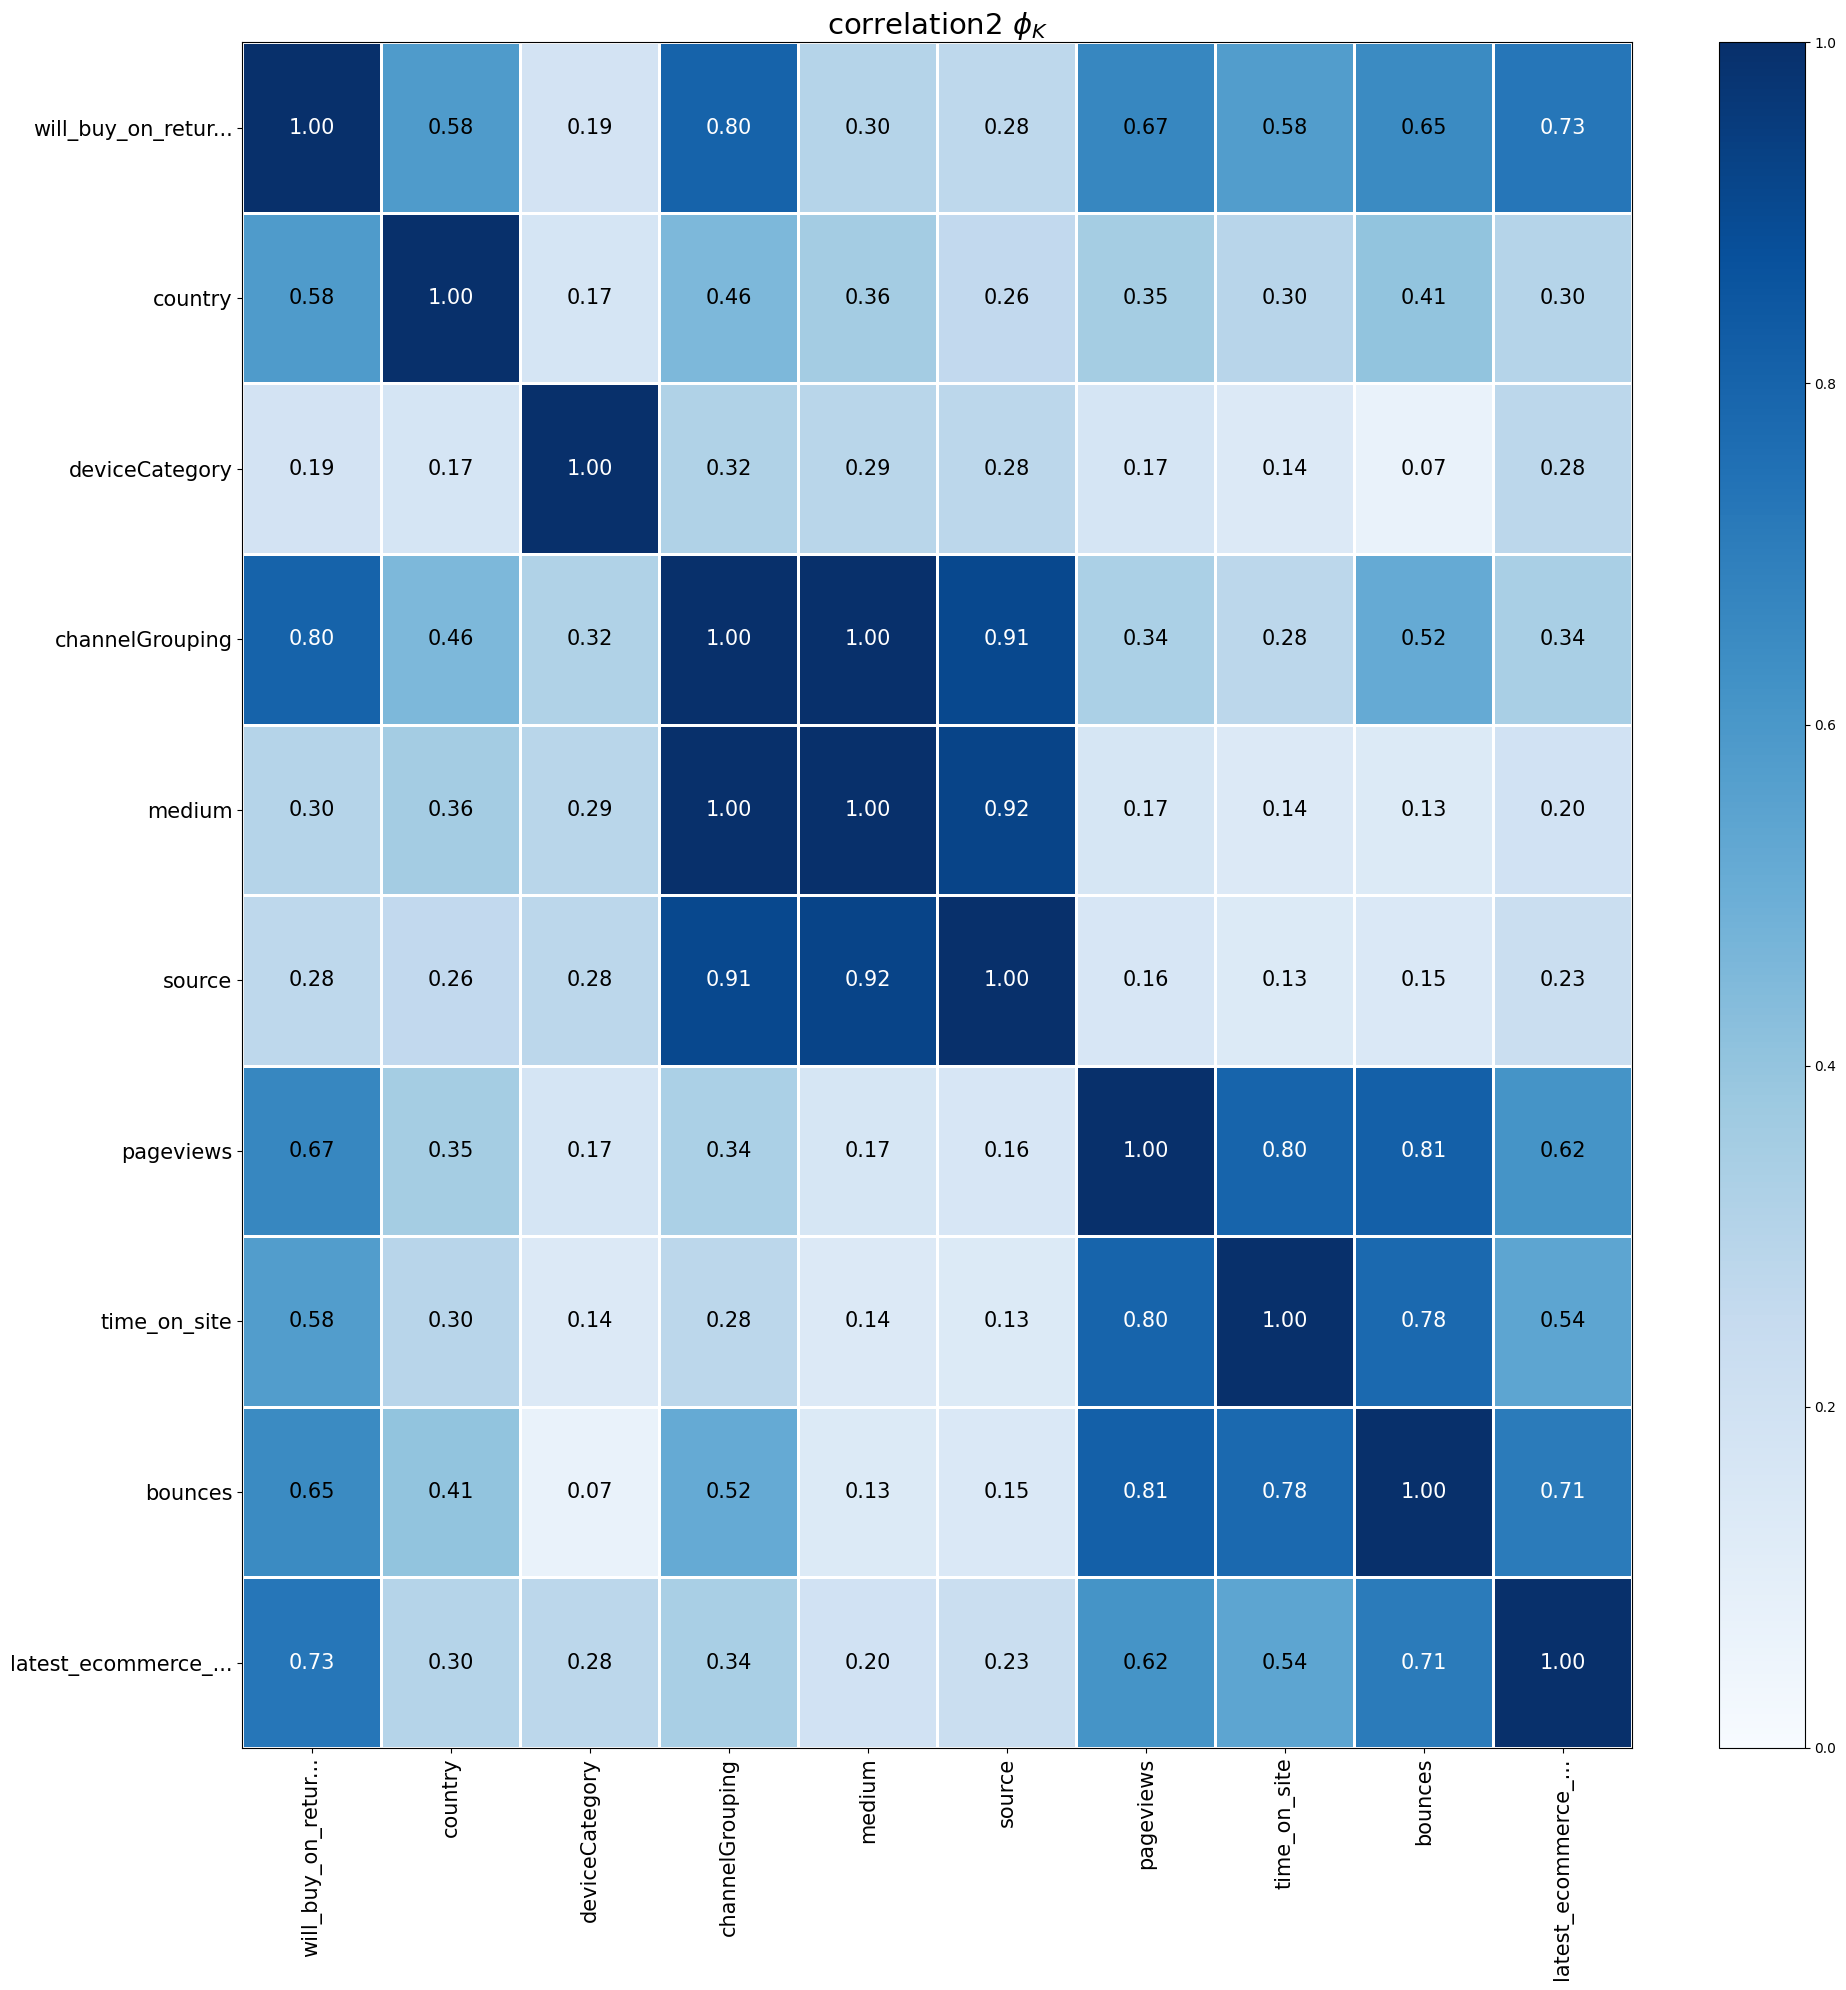

In [ ]:
# Masukan column apa saja ke dalam variabel
columns = ['latest_ecommerce_progress','bounces','time_on_site','pageviews','source','medium','channelGrouping','deviceCategory','country','will_buy_on_return_visit']

# Menghitung menggunakan Phi-K correlation
correlation2 = compute_phik_correlation(concat_train2, columns)

plot_correlation_matrix(correlation2.values, x_labels=correlation2.columns, y_labels=correlation2.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation2 $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,20))
plt.tight_layout()

Menurut https://www.andrews.edu:
- Kolerasi 0.7 - 0.9 merupakan **highly colerated**
- Kolerasi 0.5 - 0.7 merupakan **moderately colerated**
- Kolerasi 0.3 - 0.5 merupakan **low colerated**
------------------------------------------------------------------------------------------------------------------------------------------------------------------
* Berdasarkan analisis korelasi dengan mempertimbangkan kriteria dari Andrews University, saya memutuskan untuk membuang beberapa fitur dari dataset. Fitur yang memiliki nilai korelasi di bawah 0.5 terhadap target dianggap tidak memiliki kontribusi yang signifikan dalam membantu prediksi, dan oleh karena itu, kolom 'source', 'medium', dan 'deviceCategory' akan dihapus.

* Source, Medium, dan DeviceCategory dihapus karena mereka termasuk dalam kategori low to moderate correlation (korelasi di bawah 0.5), yang menunjukkan bahwa mereka hanya memiliki hubungan lemah dengan target.

* Saya juga membuang country karena jika mempertahankan fitur ini dapat menambah kompleksitas model tanpa meningkatkan akurasi yang signifikan.

Dengan membuang fitur-fitur yang kurang relevan ini, kita dapat mengurangi risiko overfitting dan membuat model lebih sederhana, serta lebih fokus pada fitur-fitur yang memiliki dampak signifikan terhadap prediksi.

In [ ]:
#Drop column that < 0.5 + country
X2_train.drop(['country','source','medium','deviceCategory'], axis = 1, inplace = True)
X2_test.drop(['country','source','medium','deviceCategory'], axis = 1, inplace = True)
X2_train

,latest_ecommerce_progress,bounces,time_on_site,pageviews,channelGrouping
0,0,0,69.0,2.0,Social
1,0,0,36.0,4.0,Organic Search
2,0,1,0.0,1.0,Social
3,0,0,22.0,2.0,Referral
4,0,1,0.0,1.0,Organic Search
...,...,...,...,...,...
982809,5,0,493.0,10.0,Referral
982810,3,0,747.5,8.0,Referral
982811,0,0,20.0,2.0,Referral
982812,2,0,212.0,11.0,Referral


* Column yang kurang relevan berhasil di drop dan menyisakan 5 column terpenting

#### Column Transformer

In [247]:
X2_train.head(1)

,latest_ecommerce_progress,bounces,time_on_site,pageviews,channelGrouping
0,0,0,69.0,2.0,Social


In [248]:
skewness2

,Column Name,Skewness Value,Distribution
0,latest_ecommerce_progress,1.2,skewed
1,bounces,0.9,skewed
2,time_on_site,4.0,skewed
3,pageviews,4.2,skewed


In [249]:
# Making column transformer for preprocessing
transformer2 = ColumnTransformer([
    ('scaler_norm', StandardScaler(), ['bounces']),
    ('scaler_skewed', MinMaxScaler(), ['time_on_site','latest_ecommerce_progress','pageviews']),
    ('ohe', OneHotEncoder(), ['channelGrouping'])  #  Menggunakan OneHotEncoder untuk fitur kategorikal
], remainder='passthrough')  # Kolom yang tidak disebutkan akan diteruskan tanpa perubahan

Transformer ini dibuat untuk melakukan preprocessing pada data. Fitur 'bounces' akan dinormalisasi dengan StandardScaler karena memang dia bentuk awalnya sudah ter encode, sedangkan fitur yang skewed ('time_on_site', 'latest_ecommerce_progress', 'pageviews') akan diskalakan menggunakan MinMaxScaler karena mereka skewed. Sementara itu, fitur kategorikal 'channelGrouping' akan diencode dengan OneHotEncoder agar bisa digunakan dalam model machine learning. Kolom lainnya diteruskan tanpa perubahan.

### **2. Model Definition**

Saya memilih Logistic Regression sebagai model untuk proyek ini karena model ini merupakan algoritma yang sederhana namun cukup efektif dalam menangani masalah klasifikasi biner seperti prediksi apakah pengguna akan melakukan pembelian atau tidak pada kunjungan berikutnya. Logistic Regression juga memiliki interpretabilitas yang tinggi, yang berarti saya bisa memahami dengan mudah hubungan antara setiap fitur dan kemungkinan outcome, sesuatu yang sangat penting dalam memberikan insight yang jelas kepada pemangku kepentingan.

Selain itu, logistic regression cenderung bekerja dengan baik ketika dataset memiliki hubungan linier antara fitur dan target. Saya juga menggunakan recall sebagai metric utama karena prioritas saya adalah meminimalkan kesalahan klasifikasi negatif (false negatives). Dengan fokus pada recall, saya ingin memastikan bahwa sebanyak mungkin pengguna potensial yang mungkin melakukan pembelian dapat diidentifikasi oleh model, yang sangat penting untuk meningkatkan konversi pelanggan. Hyperparameter seperti penalty dan regularization strength (C) akan disetel menggunakan teknik pencarian yang optimal untuk menghindari overfitting dan meningkatkan performa model.

### **3. Model Training**

In [250]:
#Making pipeline for LogReg
pipe_logreg2 = Pipeline([
('transformer', transformer2),
('classifier', LogisticRegression())
])

Membuat pipeline untuk logistic regression

In [251]:
pipe_logreg2.fit(X2_train, y2_train)
print('Training Score: ',round(pipe_logreg2.score(X2_train, y2_train),4))
print('Testing Score: ', round(pipe_logreg2.score(X2_test, y2_test),4))

Training Score:  0.8378
Testing Score:  0.804


Setelah model Logistic Regression diterapkan menggunakan pipeline yang mencakup preprocessing data, hasilnya menunjukkan skor pelatihan sebesar 83.78% dan skor pengujian sebesar 80.4%. Ini mengindikasikan bahwa model memiliki performa yang cukup baik dalam mempelajari pola dari data latih dan mempertahankan generalisasi yang baik saat diuji pada data baru. Perbedaan yang relatif kecil antara skor pelatihan dan pengujian menunjukkan bahwa model tidak mengalami overfitting yang serius.

In [253]:
y_logreg_pred2 = pipe_logreg2.predict(X2_test)
y_logreg_pred2

array([0, 0, 0, ..., 1, 0, 0])

Step ini bertujuan untuk mengevaluasi performa model dalam memprediksi apakah pengguna akan melakukan pembelian di masa depan. Dengan hasil ini, selanjutnya bisa dilakukan evaluasi lebih mendalam, seperti menghitung metrik performa (precision, recall, f1-score), untuk memastikan seberapa baik model dalam mengklasifikasikan pengguna berdasarkan data uji yang disediakan.

#### Simple Evaluation LogisticRegression

```
Saya memilih menggunakan recall sebagai metrik evaluasi karena fokus utama adalah mengidentifikasi sebanyak mungkin pengguna yang berpotensi melakukan pembelian. Recall membantu memastikan bahwa model dapat mendeteksi semua kasus positif dengan baik, mengurangi kemungkinan "false negatives" yaitu, pengguna potensial yang terlewat. Dalam konteks ini, kehilangan calon pembeli lebih merugikan dibandingkan dengan kesalahan mendeteksi pengguna yang tidak akan membeli.
```

In [254]:
target = ['Tidak melakukan pembelian', 'Akan melakukan pembelian saat mengunjungi kembali']
print(classification_report(y2_test, y_logreg_pred2, target_names = target))

                                                   precision    recall  f1-score   support

                        Tidak melakukan pembelian       1.00      0.80      0.89    122886
Akan melakukan pembelian saat mengunjungi kembali       0.06      0.87      0.12      1902

                                         accuracy                           0.80    124788
                                        macro avg       0.53      0.84      0.50    124788
                                     weighted avg       0.98      0.80      0.88    124788



Hasil evaluasi model menunjukkan bahwa model Logistic Regression memiliki recall yang sangat baik untuk kategori "Akan melakukan pembelian saat mengunjungi kembali" dengan nilai recall 0.87, yang berarti model mampu mengidentifikasi mayoritas pengguna potensial dengan baik. Namun, nilai precision untuk kategori ini sangat rendah (0.06), yang menunjukkan banyak prediksi positif yang salah. Secara keseluruhan, akurasi model berada pada 80%, tetapi ketidakseimbangan antara precision dan recall menandakan bahwa model lebih fokus pada deteksi semua calon pembeli, meskipun dengan tingkat kesalahan prediksi yang tinggi.

In [285]:
# Menghitung ROC AUC Score
roc_auc2 = roc_auc_score(y2_test, y_logreg_pred2)

result2 = check_roc_auc_score(roc_auc2)
print(f"ROC AUC Score: {roc_auc2:.3f}, Category: {result2}")

ROC AUC Score: 0.836, Category: Fair


Berdasarkan klasifikasi perusahaan, nilai ROC AUC Score sebesar 0.836 termasuk dalam kategori "Fair." Ini berarti model memiliki performa yang cukup baik dalam membedakan antara kelas positif dan negatif, menunjukkan kemampuan yang dapat diandalkan dalam mengidentifikasi pengguna potensial yang mungkin melakukan pembelian. Namun, masih ada ruang untuk peningkatan agar mencapai performa yang lebih optimal.

In [256]:
# Cross Validation
recall_train_cross_val = cross_val_score(pipe_logreg2,
                                     X2_train,
                                     y2_train,
                                     cv=3,
                                     scoring="recall")

print('recall Score - All - Cross Validation  : ', recall_train_cross_val)
print('recall Score - Mean - Cross Validation : ', recall_train_cross_val.mean())
print('recall Score - Std - Cross Validation  : ', recall_train_cross_val.std())
print('recall Score - Range of Test-Set       : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

recall Score - All - Cross Validation  :  [0.87441545 0.87246876 0.87266944]
recall Score - Mean - Cross Validation :  0.873184551127259
recall Score - Std - Cross Validation  :  0.0008742264143505508
recall Score - Range of Test-Set       :  0.8723103247129085 - 0.8740587775416095


Hasil cross-validation menunjukkan bahwa Recall Score rata-rata adalah 0.8732 dengan standar deviasi sebesar 0.0009. Ini berarti model memiliki kemampuan yang konsisten dalam mengenali kelas positif (pengguna yang mungkin melakukan pembelian) di berbagai fold data latih. Rentang Recall Score antara 0.8723 hingga 0.8741 menunjukkan stabilitas yang baik, menandakan bahwa model dapat secara andal mengidentifikasi pengguna potensial di berbagai skenario validasi tanpa banyak variasi antar fold.

#### Base Model Logistic Regression

In [257]:
models2 = {
    'Logistic Regression' : pipe_logreg2
}

metrics2 = {
    'Recall' : recall_score
}

df2_model = pd.DataFrame(columns = models2.keys())

for metric in metrics2.keys():
  for model in models2.keys():
    df2_model.loc[metric, model] = metrics2[metric](y2_test, models2[model].predict(X2_test))
df2_model

,Logistic Regression
Recall,0.869085


Model Logistic Regression menghasilkan nilai Recall sebesar 0.8691, yang menunjukkan bahwa model cukup baik dalam mengidentifikasi mayoritas pengguna yang berpotensi melakukan pembelian. Dengan nilai Recall yang tinggi, model mampu meminimalkan kasus false negatives, memastikan sebagian besar pengguna potensial teridentifikasi dengan baik.

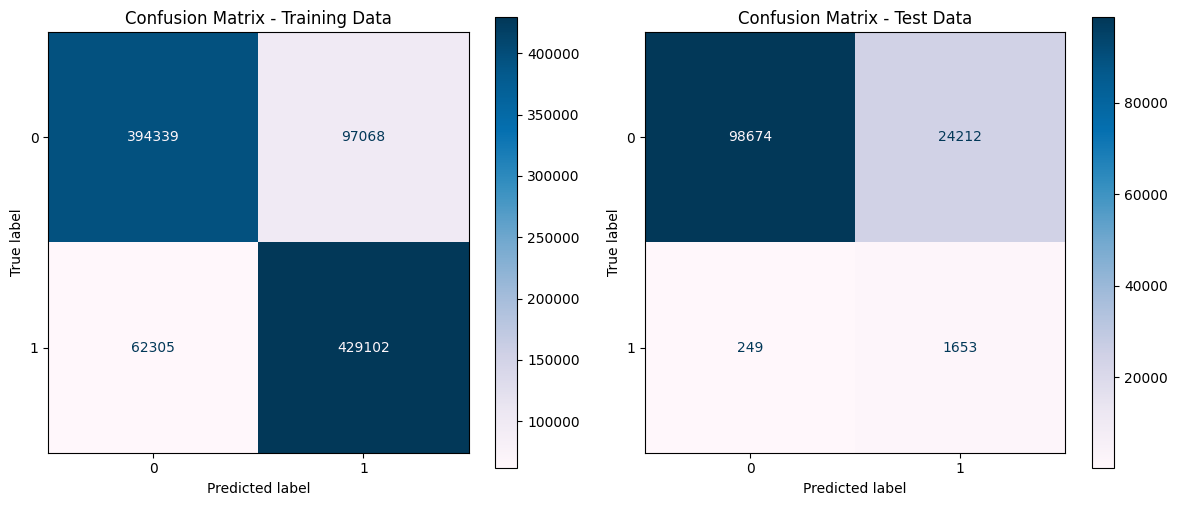

In [258]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix2 = ConfusionMatrixDisplay.from_estimator(pipe_logreg2, X2_train, y2_train, cmap='PuBu', ax=axes[0])
train_matrix2.ax_.set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for test data
test_matrix2 = ConfusionMatrixDisplay.from_estimator(pipe_logreg2, X2_test, y2_test, cmap='PuBu', ax=axes[1])
test_matrix2.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

Berdasarkan Confusion Matrix di atas, model menunjukkan performa yang cukup baik dalam mendeteksi kelas positif (pengguna yang akan melakukan pembelian) pada data uji dan data train. Pada data train, terdapat 429,102 true positives dan 62,305 false negatives, yang menunjukkan bahwa sebagian besar pengguna yang berpotensi melakukan pembelian dapat diidentifikasi dengan benar, meskipun masih terdapat sejumlah kesalahan klasifikasi negatif. Pada data uji, model berhasil mendeteksi 1,653 true positives dengan hanya 249 false negatives, menunjukkan bahwa model dapat bekerja cukup baik di data yang tidak terlihat, meskipun masih ada beberapa false positives (sekitar 24,212 pada data uji). Secara keseluruhan, model cukup baik dalam mengenali pelanggan potensial tetapi masih memiliki ruang untuk perbaikan dalam hal mengurangi false positives dan false negatives.

In [259]:
y_pred_train2 = pipe_logreg2.predict(X2_train)
y_pred_test2 = pipe_logreg2.predict(X2_test)

In [260]:
# Create function to create reports
def performance_report(all_reports2, y2_train, y_pred_train2, y2_test, y_pred_test2, name):
    # Calculate recall scores
    score_reports2 = {
        'Recall Train Set': recall_score(y2_train, y_pred_train2),
        'Recall Test Set': recall_score(y2_test, y_pred_test2),
    }

    # Calculate confusion matrices for train and test sets
    cm_train2 = confusion_matrix(y2_train, y_pred_train2)
    cm_test2 = confusion_matrix(y2_test, y_pred_test2)

    # Extract false negatives from the confusion matrices and add to the report
    score_reports2['False Negative Train'] = cm_train2[1, 0]
    score_reports2['False Negative Test'] = cm_test2[1, 0]

    # Store the report in the dictionary with the specified model name
    all_reports2[name] = score_reports2
    return all_reports2

all_reports2 = {}
all_reports2 = performance_report(all_reports2, y2_train, y_pred_train2, y2_test, y_pred_test2, 'Logistic Regresion without Tuning')

pd.DataFrame(all_reports2)

,Logistic Regresion without Tuning
Recall Train Set,0.873211
Recall Test Set,0.869085
False Negative Train,62305.000000
False Negative Test,249.000000


Sebelum dilakukan hyperparameter tuning, model Logistic Regression menunjukkan hasil dengan Recall pada data latih sebesar 0.873 dan Recall pada data uji sebesar 0.869. Ini berarti bahwa model cukup baik dalam mendeteksi pengguna yang berpotensi melakukan pembelian, dengan performa yang hampir sama di data latih dan data uji. Selain itu, terdapat 62,305 false negatives pada data latih dan 249 false negatives pada data uji, yang mengindikasikan masih adanya beberapa pengguna potensial yang tidak teridentifikasi dengan benar, meskipun persentasenya relatif kecil. Model ini sudah menunjukkan performa yang konsisten antara data latih dan uji, namun masih bisa ditingkatkan lebih lanjut untuk meminimalkan kesalahan deteksi negatif.

### **4. Model Evaluation**

#### Hyperparemeter Tuning

In [ ]:
# Set up the parameter

param_grid_lr2 = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 200, 500],
    'classifier__class_weight': [None, 'balanced']
}

# Set up the GridSearchCV object for Random Forest
grid_search_lr2 = RandomizedSearchCV(pipe_logreg2,
                                    param_distributions=param_grid_lr2,
                                    scoring='recall',
                                    cv=5,
                                    verbose=2,
                                    n_jobs=-1)

# Fit GridSearchCV for Logistic Regression
grid_search_lr2.fit(X2_train, y2_train)

# Best hyperparameters for logreg
print('Best hyperparameters for Logistic Regression:', grid_search_lr2.best_params_)

# Best recall for Logistic Regression
print('Best recall for Logistic Regression:', grid_search_lr2.best_score_)

# Save best Logistic Regression model to a variable
best_lr_model2 = grid_search_lr2.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for Logistic Regression: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__max_iter': 200, 'classifier__class_weight': None, 'classifier__C': 100}
Best recall for Logistic Regression: 0.8733351402280171


Best parameter:

* solver: liblinear
* penalty: l2
* max_iter: 200
* Class_weight: None
* C: 100

In [262]:
# Dapatkan prediksi untuk data latih dan data uji menggunakan model yang sudah dituning hyperparameter-nya.
y_pred_train_tuned2 = best_lr_model2.predict(X2_train)
y_pred_test_tuned2 = best_lr_model2.predict(X2_test)

In [263]:
# print(recall_score(y_test, y_pred_test_tuned))
print('Recall Score - Train Set  : ', recall_score(y2_train, y_pred_train_tuned2))
print('Recall Score - Test Set   : ', recall_score(y2_test, y_pred_test_tuned2))

Recall Score - Train Set  :  0.8734755508163294
Recall Score - Test Set   :  0.8690851735015773


Setelah dilakukan hyperparameter tuning, model Logistic Regression menunjukkan peningkatan Recall pada data latih sebesar 0.873 dan Recall pada data uji sebesar 0.869. Artinya, hasil recall tetap stabil dengan sedikit peningkatan, menunjukkan bahwa model semakin baik dalam mengenali pengguna yang berpotensi melakukan pembelian. Tuning yang dilakukan berhasil mempertahankan konsistensi performa model pada data latih dan data uji, sehingga mengurangi kemungkinan overfitting dan membuat model lebih andal dalam prediksi nyata.

In [264]:
y_logreg_pred3 = best_lr_model2.predict(X2_test)
y_logreg_pred3

array([0, 0, 0, ..., 1, 0, 0])

In [286]:
# Menghitung ROC AUC Score
roc_auc3 = roc_auc_score(y2_test, y_logreg_pred3)

result3 = check_roc_auc_score(roc_auc3)
print(f"ROC AUC Score: {roc_auc3:.3f}, Category: {result3}")

ROC AUC Score: 0.836, Category: Fair


Dengan ROC AUC Score sebesar 0.836, model berada pada kategori Fair menurut klasifikasi perusahaan. Ini menunjukkan bahwa kemampuan model untuk membedakan antara kelas positif dan negatif cukup baik. Meskipun masih ada ruang untuk perbaikan, model ini sudah dapat digunakan dengan hasil yang layak untuk mendeteksi pengguna yang berpotensi melakukan pembelian.

In [266]:
# Add results to the report
all_reports2 = performance_report(all_reports2, y2_train, y_pred_train_tuned2, y2_test, y_pred_test_tuned2, 'Logistic Regresion with Tuning')
pd.DataFrame(all_reports2)

,Logistic Regresion without Tuning,Logistic Regresion with Tuning
Recall Train Set,0.873211,0.873476
Recall Test Set,0.869085,0.869085
False Negative Train,62305.000000,62175.000000
False Negative Test,249.000000,249.000000


Setelah melakukan hyperparameter tuning, Recall pada data latih sedikit meningkat dari 0.8732 menjadi 0.8735, sementara nilai Recall pada data uji tetap stabil di 0.8691. Selain itu, jumlah False Negatives pada data latih berkurang dari 62,305 menjadi 62,175, menunjukkan peningkatan kecil dalam kemampuan model untuk mendeteksi kelas positif. Pada data uji, jumlah False Negatives tidak berubah, tetap di 249. Secara keseluruhan, tuning hyperparameter memberikan perbaikan minor pada kemampuan model untuk mengenali pengguna potensial yang akan melakukan pembelian, namun performa pada data uji tetap sama.

#### Confusion Matrix Setelah Tuning Logistic Regression

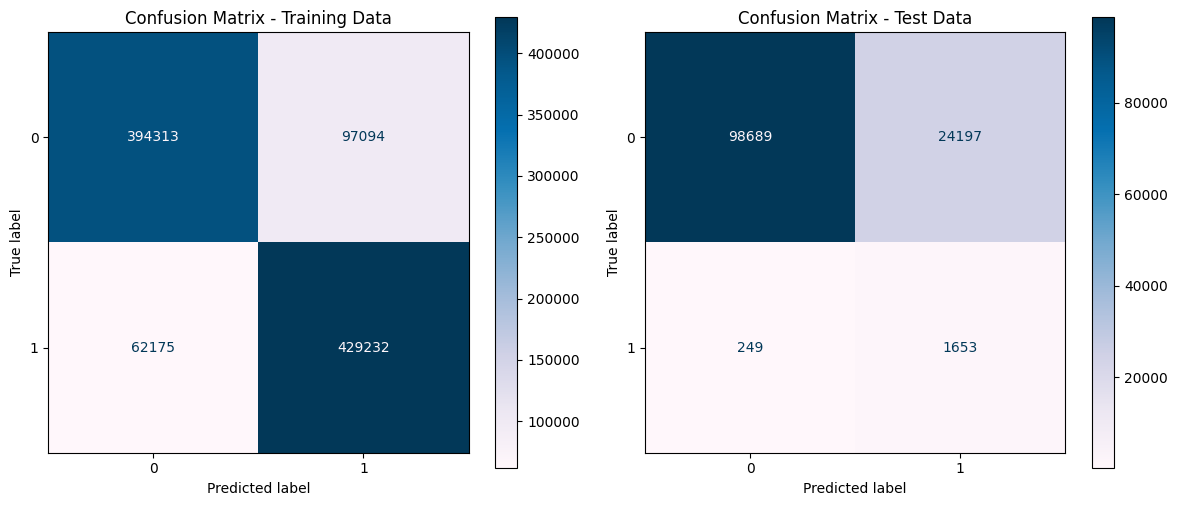

In [267]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix2 = ConfusionMatrixDisplay.from_estimator(best_lr_model2, X2_train, y2_train, cmap='PuBu', ax=axes[0])
train_matrix2.ax_.set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for test data
test_matrix2 = ConfusionMatrixDisplay.from_estimator(best_lr_model2, X2_test, y2_test, cmap='PuBu', ax=axes[1])
test_matrix2.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

Setelah melakukan hyperparameter tuning, Confusion Matrix menunjukkan bahwa model telah melakukan perbaikan yang kecil namun signifikan. Pada data latih, True Positives meningkat menjadi 429,232, sedangkan False Negatives turun menjadi 62,175. Ini menunjukkan peningkatan dalam kemampuan model untuk mendeteksi kelas positif pada data latih. Pada data uji, hasil yang lebih seimbang juga ditunjukkan dengan 1,653 True Positives dan 249 False Negatives, yang tetap konsisten setelah tuning. Meskipun model masih menghasilkan sejumlah False Positives (misalnya, 24,197 pada data uji), ini tetap menunjukkan bahwa model dapat lebih baik dalam mengenali pengguna potensial, meski ada ruang untuk lebih banyak perbaikan.

In [268]:
# Cross Validation
recall_train_cross_val2 = cross_val_score(best_lr_model2,
                                     X2_train,
                                     y2_train,
                                     cv=3,
                                     scoring="recall")

print('recall Score - All - Cross Validation  : ', recall_train_cross_val2)
print('recall Score - Mean - Cross Validation : ', recall_train_cross_val2.mean())
print('recall Score - Std - Cross Validation  : ', recall_train_cross_val2.std())
print('recall Score - Range of Test-Set       : ', (recall_train_cross_val2.mean()-recall_train_cross_val2.std()) , '-', (recall_train_cross_val2.mean()+recall_train_cross_val2.std()))

recall Score - All - Cross Validation  :  [0.87441545 0.87258475 0.87295637]
recall Score - Mean - Cross Validation :  0.8733188593856176
recall Score - Std - Cross Validation  :  0.0007901112785587284
recall Score - Range of Test-Set       :  0.8725287481070588 - 0.8741089706641764


# **IX. Model Saving**

In [269]:
# Save the best model
with open('best_lr_model2.pkl', 'wb') as model_file:
  pickle.dump(best_lr_model2, model_file)

# **X. Kesimpulan**

#### Kesimpulan EDA

1. Pengaruh Fitur bounces, time_on_site, dan pageviews dalam Memprediksi will_buy_on_return_visit
Dari analisis korelasi, ketiga fitur ini (bounces, time_on_site, dan pageviews) memiliki nilai `korelasi yang rendah` terhadap target will_buy_on_return_visit. Nilai korelasi masing-masing fitur berada di bawah 0.2, menunjukkan bahwa fitur-fitur tersebut tidak memiliki pengaruh yang cukup signifikan dalam memprediksi target. Oleh karena itu, ketiga fitur tersebut mungkin tidak ideal untuk digunakan sebagai prediktor utama.

2. Jenis Device yang Paling Sering Digunakan oleh User di Wilayah Canada yang Berpotensi Melakukan Pembelian
Dari hasil analisis, dapat disimpulkan bahwa device `desktop` merupakan jenis perangkat yang paling sering digunakan oleh pengguna di Canada yang berpotensi melakukan pembelian ketika kembali mengunjungi website. Analisis ini berdasarkan filter data pada deviceCategory untuk wilayah Canada dengan target yang bernilai positif (will_buy_on_return_visit = 1).

#### Kesimpulan Model

Dari seluruh analisis yang telah dilakukan, dapat disimpulkan bahwa model Logistic Regression mengalami beberapa peningkatan performa setelah penambahan fitur dan penerapan hyperparameter tuning.

1. Evaluasi Model Setelah Penambahan Fitur
Setelah menambahkan fitur yang relevan dan melakukan tuning, model menunjukkan `performa yang lebih baik`. Hasil dari evaluasi Confusion Matrix menunjukkan adanya peningkatan pada True Positives dan `penurunan False Negatives` baik pada data train maupun data test, meskipun peningkatannya tidak drastis. Ini menunjukkan bahwa penambahan fitur telah memberikan dampak positif dalam memperbaiki kemampuan model untuk mendeteksi kelas positif.

2. Apakah Model Overfit, Good-fit, atau Underfit?
Model menunjukkan hasil yang `good-fit setelah hyperparameter tuning`. Meskipun terdapat perbedaan antara Training Score dan Testing Score, perbedaannya tidak signifikan, menunjukkan bahwa model tidak mengalami overfitting. Model mampu menangkap pola yang baik dari data tanpa terlalu bergantung pada data train.

3. Evaluasi dengan ROC AUC Score
Nilai ROC AUC Score sebesar 0.836 menunjukkan bahwa model memiliki performa yang baik dalam membedakan antara kelas positif dan negatif. Berdasarkan klasifikasi perusahaan dimana: 
      * Good: Jika roc_auc_score lebih besar dari 0.9.
      * Fair: Jika roc_auc_score kurang dari sama dengan 0.9 dan lebih besar dari sama dengan 0.8.
      * Decent: Jika roc_auc_score kurang dari 0.8 dan lebih besar sama dengan dari 0.7.
      * Not Great: Jika roc_auc_score kurang dari 0.7 dan lebih besar dari sama dengan 0.6.
      * Poor: Jika roc_auc_score kurang dari 0.6.

      Skor ini masuk kategori `Fair karena berada antara 0.8 dan 0.9`.

4. Apakah ROC AUC Score merupakan metrik terbaik? 

      Jawabannya adalah tidak. Dalam kasus ini, di mana tujuan utama adalah mengurangi False Negatives dan meningkatkan kemampuan untuk mendeteksi calon pembeli, `Recall lebih cocok untuk mengevaluasi performa model`. Dengan fokus pada Recall, model dapat meminimalkan kehilangan pelanggan potensial.

5. Hyperparameter Tuning dengan Fitur Seleksi dan Evaluasi Hasilnya
Setelah hyperparameter tuning, model menunjukkan `hasil yang lebih baik` dengan penurunan False Negatives baik pada data train maupun data test. Recall juga mengalami peningkatan, yang mengindikasikan kemampuan model untuk lebih baik dalam mendeteksi kelas positif (yaitu pengguna yang akan melakukan pembelian).

Rekomendasi Selanjutnya:
* Penambahan Fitur yang Lebih Relevan: Disarankan untuk mengeksplorasi fitur tambahan yang mungkin memiliki korelasi lebih tinggi dengan target, seperti interaksi pada halaman produk atau aktivitas pengguna dalam keranjang belanja.
* Model Tuning Lebih Lanjut: Model bisa lebih ditingkatkan lagi dengan mengeksplorasi algoritma lain seperti Random Forest atau Gradient Boosting yang dapat menangkap pola non-linear, mengingat data e-commerce umumnya memiliki kompleksitas yang lebih tinggi.


Secara Keseluruhan:

Model ini mampu meningkatkan deteksi pengguna potensial dengan recall yang lebih tinggi, yang berarti kampanye pemasaran dapat lebih ditargetkan. Analisis mendalam pada fitur seperti time_on_site dan bounces juga membantu dalam personalisasi penawaran. ROC AUC Score sebesar 0.836 menunjukkan kemampuan model yang cukup baik dalam mengklasifikasikan kelas positif dan negatif, membantu perusahaan mengurangi calon pelanggan yang "terlewat."
Secara keseluruhan, model ini berhasil mendukung tujuan identifikasi pelanggan potensial dan meningkatkan efisiensi kampanye pemasaran. Namun, penambahan fitur yang lebih relevan dan penggunaan algoritma lain masih diperlukan untuk lebih meningkatkan akurasi dan efektivitas model.